In [1]:
!nvidia-smi

Fri Mar  1 17:24:01 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   41C    P2              47W / 215W |    514MiB /  8192MiB |      3%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import glob
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
os.chdir('../../')
os.getcwd()

'/home/linh/projects/IConNet'

In [5]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
import traceback
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

data_dir = '../data/physionet/fold1/'

cuda


In [ ]:
sr = 16000

x_train = np.load(f'{data_dir}heartsound.audio16k.train.npy', allow_pickle=True)
x_test = np.load(f'{data_dir}heartsound.audio16k.test.npy', allow_pickle=True)
classnames = np.load(f'{data_dir}heartsound.classnames.npy', allow_pickle=True)
y_train = np.load(f'{data_dir}heartsound.labels_binary.train.npy', allow_pickle=True)
y_test = np.load(f'{data_dir}heartsound.labels_binary.test.npy', allow_pickle=True)

In [7]:
from einops import rearrange, reduce, repeat
from torch.utils.data import TensorDataset, DataLoader

def create_data_loader(x_train, y_train, 
                       x_test, y_test, batch_size=32):
    x_train = torch.tensor(x_train)[:, None ,:]
    y_train = torch.tensor(y_train)
    x_test = torch.tensor(x_test)[:, None, :]
    y_test = torch.tensor(y_test)
    train_data = TensorDataset(x_train, y_train)
    test_data = TensorDataset(x_test, y_test)
    
    train_loader = DataLoader(train_data, shuffle=False, 
                              batch_size=batch_size, drop_last=True)
    test_loader = DataLoader(test_data, shuffle=True, 
                             batch_size=batch_size, drop_last=True)
    return train_loader, test_loader

In [8]:
batch_size = 32
train_loader, test_loader = create_data_loader(x_train, y_train, 
                       x_test, y_test, batch_size=batch_size)
labels = classnames

In [10]:
from IConNet.nn.model import M13mfcc as M13
from omegaconf import OmegaConf as ocf
from IConNet.visualizer import visualize_model

model_config_path = 'config/model/m13mfcc_sm.yaml'
model_config = ocf.load(model_config_path)
print(ocf.to_yaml(model_config))
model = M13(config=model_config,
           n_input=1, n_output=2)
print(model)

print(f'total parameters: {visualize_model.count_parameters(model)}')

name: M13mfcc
description: FirConv with fftconv
mfcc:
  n_mfcc: 40
  n_fft: 512
  hop_length: 128
  n_mels: 64
  sample_rate: 16000
pooling: mean
cls:
  n_block: 2
  n_hidden_dim:
  - 256
  - 256
  norm_type: LayerNorm

M13mfcc(
  (mfcc): MFCC(
    (amplitude_to_DB): AmplitudeToDB()
    (MelSpectrogram): MelSpectrogram(
      (spectrogram): Spectrogram()
      (mel_scale): MelScale()
    )
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (norm): LayerNorm((40,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=40, out_features=256, bias=True)
      )
      (1): Sequential(
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=256, out_features=256, bias=True)
      )
    )
    (act): LeakyReLU(negative_slope=0.01)
    (output_layer): Linear(in_features=256, out_features=2, bias=True)
  )
)
total parameters: 77394


In [11]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [12]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            _mem_before = torch.cuda.memory_allocated()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            _mem_during = torch.cuda.memory_allocated()
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
            _mem_after = torch.cuda.memory_allocated()
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                print(f'Mem before-during-after: {_mem_before} {_mem_during} {_mem_after}')
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data.shape} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

@torch.no_grad
def test(model, epoch):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc

In [13]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                                                                                         | 0.004123711340206186/10 [00:00<20:19, 121.97s/it]

Train Epoch: 1 [0/11805 (0%)]	Loss: 0.820520
Mem before-during-after: 389120 9054720 18361856


  1%|▉                                                                                                          | 0.08659793814432996/10 [00:07<14:13, 86.09s/it]

Train Epoch: 1 [1280/11805 (11%)]	Loss: 0.412082
Mem before-during-after: 18361856 18506752 18361856


  2%|█▊                                                                                                         | 0.16907216494845365/10 [00:14<14:27, 88.24s/it]

Train Epoch: 1 [2560/11805 (22%)]	Loss: 0.394908
Mem before-during-after: 18361856 18506752 18361856


  3%|██▋                                                                                                         | 0.2515463917525771/10 [00:22<14:05, 86.69s/it]

Train Epoch: 1 [3840/11805 (33%)]	Loss: 0.697590
Mem before-during-after: 18361856 18506752 18361856


  3%|███▌                                                                                                        | 0.3340206185567005/10 [00:29<14:13, 88.32s/it]

Train Epoch: 1 [5120/11805 (43%)]	Loss: 0.215371
Mem before-during-after: 18361856 18506752 18361856


  4%|████▍                                                                                                      | 0.41649484536082393/10 [00:36<13:57, 87.38s/it]

Train Epoch: 1 [6400/11805 (54%)]	Loss: 0.738282
Mem before-during-after: 18361856 18506752 18361856


  5%|█████▎                                                                                                     | 0.49896907216494735/10 [00:43<13:41, 86.50s/it]

Train Epoch: 1 [7680/11805 (65%)]	Loss: 0.622403
Mem before-during-after: 18361856 18506752 18361856


  6%|██████▎                                                                                                     | 0.5814432989690708/10 [00:50<13:39, 87.02s/it]

Train Epoch: 1 [8960/11805 (76%)]	Loss: 0.356729
Mem before-during-after: 18361856 18506752 18361856


  7%|███████▏                                                                                                    | 0.6639175257731942/10 [00:57<13:06, 84.21s/it]

Train Epoch: 1 [10240/11805 (87%)]	Loss: 0.164973
Mem before-during-after: 18361856 18506752 18361856


  7%|████████                                                                                                    | 0.7443298969072145/10 [01:04<13:27, 87.21s/it]

Train Epoch: 1 [11520/11805 (98%)]	Loss: 0.273245
Mem before-during-after: 18361856 18506752 18361856


 10%|██████████▊                                                                                                 | 0.9999999999999971/10 [01:26<12:42, 84.73s/it]


Test Epoch: 1	Accuracy: 2885/3744 (77%)



 10%|██████████▊                                                                                                 | 1.0041237113402033/10 [01:27<13:05, 87.35s/it]

Train Epoch: 2 [0/11805 (0%)]	Loss: 0.847103
Mem before-during-after: 18360832 18506752 18361856


 11%|███████████▋                                                                                                | 1.0865979381443267/10 [01:34<12:54, 86.92s/it]

Train Epoch: 2 [1280/11805 (11%)]	Loss: 0.302771
Mem before-during-after: 18361856 18506752 18361856


 12%|████████████▋                                                                                               | 1.1690721649484501/10 [01:41<12:27, 84.67s/it]

Train Epoch: 2 [2560/11805 (22%)]	Loss: 0.129949
Mem before-during-after: 18361856 18506752 18361856


 12%|█████████████▍                                                                                              | 1.2494845360824705/10 [01:48<12:30, 85.76s/it]

Train Epoch: 2 [3840/11805 (33%)]	Loss: 0.969470
Mem before-during-after: 18361856 18506752 18361856


 13%|██████████████▌                                                                                              | 1.334020618556697/10 [01:55<12:19, 85.30s/it]

Train Epoch: 2 [5120/11805 (43%)]	Loss: 0.313427
Mem before-during-after: 18361856 18506752 18361856


 14%|███████████████▎                                                                                            | 1.4164948453608204/10 [02:02<12:32, 87.69s/it]

Train Epoch: 2 [6400/11805 (54%)]	Loss: 0.893452
Mem before-during-after: 18361856 18506752 18361856


 15%|████████████████▏                                                                                           | 1.4989690721649438/10 [02:09<11:49, 83.48s/it]

Train Epoch: 2 [7680/11805 (65%)]	Loss: 1.147878
Mem before-during-after: 18361856 18506752 18361856


 16%|█████████████████                                                                                           | 1.5793814432989641/10 [02:16<11:52, 84.60s/it]

Train Epoch: 2 [8960/11805 (76%)]	Loss: 0.282080
Mem before-during-after: 18361856 18506752 18361856


 17%|█████████████████▉                                                                                          | 1.6639175257731906/10 [02:24<12:11, 87.75s/it]

Train Epoch: 2 [10240/11805 (87%)]	Loss: 0.079004
Mem before-during-after: 18361856 18506752 18361856


 17%|███████████████████                                                                                          | 1.746391752577314/10 [02:31<11:50, 86.08s/it]

Train Epoch: 2 [11520/11805 (98%)]	Loss: 0.233018
Mem before-during-after: 18361856 18506752 18361856


 20%|█████████████████████▊                                                                                       | 2.002061855670097/10 [02:53<11:30, 86.33s/it]


Test Epoch: 2	Accuracy: 2961/3744 (79%)

Train Epoch: 3 [0/11805 (0%)]	Loss: 1.464478
Mem before-during-after: 18360832 18506752 18361856


 21%|██████████████████████▌                                                                                     | 2.0865979381443234/10 [03:00<11:18, 85.73s/it]

Train Epoch: 3 [1280/11805 (11%)]	Loss: 0.040239
Mem before-during-after: 18361856 18506752 18361856


 22%|███████████████████████▋                                                                                     | 2.169072164948447/10 [03:07<10:48, 82.77s/it]

Train Epoch: 3 [2560/11805 (22%)]	Loss: 0.159801
Mem before-during-after: 18361856 18506752 18361856


 23%|████████████████████████▊                                                                                     | 2.25154639175257/10 [03:14<10:48, 83.67s/it]

Train Epoch: 3 [3840/11805 (33%)]	Loss: 0.969681
Mem before-during-after: 18361856 18506752 18361856


 23%|█████████████████████████▏                                                                                  | 2.3340206185566936/10 [03:22<11:07, 87.02s/it]

Train Epoch: 3 [5120/11805 (43%)]	Loss: 0.122437
Mem before-during-after: 18361856 18506752 18361856


 24%|██████████████████████████▎                                                                                  | 2.416494845360817/10 [03:29<10:45, 85.13s/it]

Train Epoch: 3 [6400/11805 (54%)]	Loss: 0.914956
Mem before-during-after: 18361856 18506752 18361856


 25%|██████████████████████████▉                                                                                 | 2.4989690721649405/10 [03:36<10:35, 84.72s/it]

Train Epoch: 3 [7680/11805 (65%)]	Loss: 0.961048
Mem before-during-after: 18361856 18506752 18361856


 26%|████████████████████████████▏                                                                                | 2.581443298969064/10 [03:43<10:27, 84.60s/it]

Train Epoch: 3 [8960/11805 (76%)]	Loss: 0.173587
Mem before-during-after: 18361856 18506752 18361856


 27%|████████████████████████████▊                                                                               | 2.6639175257731873/10 [03:50<10:24, 85.12s/it]

Train Epoch: 3 [10240/11805 (87%)]	Loss: 0.079581
Mem before-during-after: 18361856 18506752 18361856


 27%|█████████████████████████████▋                                                                              | 2.7463917525773107/10 [03:57<10:19, 85.45s/it]

Train Epoch: 3 [11520/11805 (98%)]	Loss: 0.330180
Mem before-during-after: 18361856 18506752 18361856


 30%|████████████████████████████████▍                                                                           | 3.0020618556700933/10 [04:19<09:56, 85.17s/it]


Test Epoch: 3	Accuracy: 3009/3744 (80%)

Train Epoch: 4 [0/11805 (0%)]	Loss: 1.212668
Mem before-during-after: 18360832 18506752 18361856


 31%|█████████████████████████████████▎                                                                          | 3.0845360824742167/10 [04:26<09:30, 82.54s/it]

Train Epoch: 4 [1280/11805 (11%)]	Loss: 0.016714
Mem before-during-after: 18361856 18506752 18361856


 32%|██████████████████████████████████▏                                                                         | 3.1690721649484432/10 [04:33<09:39, 84.86s/it]

Train Epoch: 4 [2560/11805 (22%)]	Loss: 0.139050
Mem before-during-after: 18361856 18506752 18361856


 33%|███████████████████████████████████                                                                         | 3.2515463917525667/10 [04:40<09:46, 86.94s/it]

Train Epoch: 4 [3840/11805 (33%)]	Loss: 0.801272
Mem before-during-after: 18361856 18506752 18361856


 33%|████████████████████████████████████▋                                                                         | 3.33402061855669/10 [04:47<09:31, 85.73s/it]

Train Epoch: 4 [5120/11805 (43%)]	Loss: 0.123634
Mem before-during-after: 18361856 18506752 18361856


 34%|████████████████████████████████████▉                                                                       | 3.4164948453608135/10 [04:54<09:17, 84.68s/it]

Train Epoch: 4 [6400/11805 (54%)]	Loss: 0.948861
Mem before-during-after: 18361856 18506752 18361856


 35%|██████████████████████████████████████▏                                                                      | 3.498969072164937/10 [05:02<09:35, 88.53s/it]

Train Epoch: 4 [7680/11805 (65%)]	Loss: 1.050296
Mem before-during-after: 18361856 18506752 18361856


 36%|██████████████████████████████████████▋                                                                     | 3.5814432989690603/10 [05:09<09:09, 85.54s/it]

Train Epoch: 4 [8960/11805 (76%)]	Loss: 0.173016
Mem before-during-after: 18361856 18506752 18361856


 37%|███████████████████████████████████████▌                                                                    | 3.6639175257731837/10 [05:16<08:51, 83.91s/it]

Train Epoch: 4 [10240/11805 (87%)]	Loss: 0.095102
Mem before-during-after: 18361856 18506752 18361856


 37%|████████████████████████████████████████▊                                                                    | 3.746391752577307/10 [05:23<08:59, 86.28s/it]

Train Epoch: 4 [11520/11805 (98%)]	Loss: 0.409675
Mem before-during-after: 18361856 18506752 18361856


 40%|███████████████████████████████████████████▏                                                                | 3.9999999999999867/10 [05:45<08:32, 85.41s/it]


Test Epoch: 4	Accuracy: 3021/3744 (80%)



 40%|███████████████████████████████████████████▋                                                                 | 4.004123711340193/10 [05:45<08:46, 87.82s/it]

Train Epoch: 5 [0/11805 (0%)]	Loss: 0.944956
Mem before-during-after: 18360832 18506752 18361856


 41%|████████████████████████████████████████████▌                                                                | 4.086597938144316/10 [05:52<08:12, 83.21s/it]

Train Epoch: 5 [1280/11805 (11%)]	Loss: 0.066725
Mem before-during-after: 18361856 18506752 18361856


 42%|█████████████████████████████████████████████▊                                                                | 4.16907216494844/10 [05:59<08:24, 86.46s/it]

Train Epoch: 5 [2560/11805 (22%)]	Loss: 0.187104
Mem before-during-after: 18361856 18506752 18361856


 43%|██████████████████████████████████████████████▎                                                              | 4.251546391752563/10 [06:06<08:13, 85.85s/it]

Train Epoch: 5 [3840/11805 (33%)]	Loss: 0.331220
Mem before-during-after: 18361856 18506752 18361856


 43%|██████████████████████████████████████████████▊                                                             | 4.3340206185566865/10 [06:13<08:08, 86.27s/it]

Train Epoch: 5 [5120/11805 (43%)]	Loss: 0.128433
Mem before-during-after: 18361856 18506752 18361856


 44%|████████████████████████████████████████████████▌                                                             | 4.41649484536081/10 [06:21<07:59, 85.92s/it]

Train Epoch: 5 [6400/11805 (54%)]	Loss: 0.918656
Mem before-during-after: 18361856 18506752 18361856


 45%|█████████████████████████████████████████████████                                                            | 4.498969072164933/10 [06:28<08:18, 90.65s/it]

Train Epoch: 5 [7680/11805 (65%)]	Loss: 1.147133
Mem before-during-after: 18361856 18506752 18361856


 46%|█████████████████████████████████████████████████▉                                                           | 4.581443298969057/10 [06:35<07:37, 84.49s/it]

Train Epoch: 5 [8960/11805 (76%)]	Loss: 0.167457
Mem before-during-after: 18361856 18506752 18361856


 47%|███████████████████████████████████████████████████▎                                                          | 4.66391752577318/10 [06:42<07:58, 89.63s/it]

Train Epoch: 5 [10240/11805 (87%)]	Loss: 0.098222
Mem before-during-after: 18361856 18506752 18361856


 47%|███████████████████████████████████████████████████▋                                                         | 4.746391752577304/10 [06:49<07:23, 84.45s/it]

Train Epoch: 5 [11520/11805 (98%)]	Loss: 0.409354
Mem before-during-after: 18361856 18506752 18361856


 50%|██████████████████████████████████████████████████████▌                                                      | 5.002061855670086/10 [07:11<06:59, 83.85s/it]


Test Epoch: 5	Accuracy: 3053/3744 (81%)

Train Epoch: 6 [0/11805 (0%)]	Loss: 1.137209
Mem before-during-after: 18360832 18506752 18361856


 51%|███████████████████████████████████████████████████████▉                                                      | 5.08453608247421/10 [07:18<06:50, 83.43s/it]

Train Epoch: 6 [1280/11805 (11%)]	Loss: 0.046935
Mem before-during-after: 18361856 18506752 18361856


 52%|████████████████████████████████████████████████████████▎                                                    | 5.169072164948436/10 [07:26<07:07, 88.49s/it]

Train Epoch: 6 [2560/11805 (22%)]	Loss: 0.397406
Mem before-during-after: 18361856 18506752 18361856


 53%|████████████████████████████████████████████████████████▋                                                   | 5.2515463917525596/10 [07:33<06:40, 84.35s/it]

Train Epoch: 6 [3840/11805 (33%)]	Loss: 0.159319
Mem before-during-after: 18361856 18506752 18361856


 53%|██████████████████████████████████████████████████████████▏                                                  | 5.334020618556683/10 [07:40<06:50, 87.97s/it]

Train Epoch: 6 [5120/11805 (43%)]	Loss: 0.154473
Mem before-during-after: 18361856 18506752 18361856


 54%|███████████████████████████████████████████████████████████                                                  | 5.416494845360806/10 [07:47<06:51, 89.67s/it]

Train Epoch: 6 [6400/11805 (54%)]	Loss: 0.952956
Mem before-during-after: 18361856 18506752 18361856


 55%|████████████████████████████████████████████████████████████▍                                                 | 5.49896907216493/10 [07:55<06:29, 86.48s/it]

Train Epoch: 6 [7680/11805 (65%)]	Loss: 0.887783
Mem before-during-after: 18361856 18506752 18361856


 56%|████████████████████████████████████████████████████████████▊                                                | 5.581443298969053/10 [08:02<06:12, 84.22s/it]

Train Epoch: 6 [8960/11805 (76%)]	Loss: 0.164661
Mem before-during-after: 18361856 18506752 18361856


 57%|█████████████████████████████████████████████████████████████▋                                               | 5.663917525773177/10 [08:09<06:08, 85.07s/it]

Train Epoch: 6 [10240/11805 (87%)]	Loss: 0.104407
Mem before-during-after: 18361856 18506752 18361856


 57%|███████████████████████████████████████████████████████████████▊                                               | 5.7463917525773/10 [08:16<06:12, 87.61s/it]

Train Epoch: 6 [11520/11805 (98%)]	Loss: 0.379291
Mem before-during-after: 18361856 18506752 18361856


 60%|█████████████████████████████████████████████████████████████████▍                                           | 6.002061855670083/10 [08:38<05:46, 86.67s/it]


Test Epoch: 6	Accuracy: 3083/3744 (82%)

Train Epoch: 7 [0/11805 (0%)]	Loss: 1.041981
Mem before-during-after: 18360832 18506752 18361856


 61%|██████████████████████████████████████████████████████████████████▎                                          | 6.086597938144309/10 [08:45<05:29, 84.09s/it]

Train Epoch: 7 [1280/11805 (11%)]	Loss: 0.030593
Mem before-during-after: 18361856 18506752 18361856


 62%|███████████████████████████████████████████████████████████████████▏                                         | 6.169072164948433/10 [08:53<05:31, 86.56s/it]

Train Epoch: 7 [2560/11805 (22%)]	Loss: 0.190389
Mem before-during-after: 18361856 18506752 18361856


 63%|████████████████████████████████████████████████████████████████████▏                                        | 6.251546391752556/10 [09:00<05:10, 82.75s/it]

Train Epoch: 7 [3840/11805 (33%)]	Loss: 0.291066
Mem before-during-after: 18361856 18506752 18361856


 63%|█████████████████████████████████████████████████████████████████████                                        | 6.334020618556679/10 [09:07<05:17, 86.63s/it]

Train Epoch: 7 [5120/11805 (43%)]	Loss: 0.110616
Mem before-during-after: 18361856 18506752 18361856


 64%|█████████████████████████████████████████████████████████████████████▉                                       | 6.416494845360803/10 [09:14<04:57, 83.07s/it]

Train Epoch: 7 [6400/11805 (54%)]	Loss: 0.863008
Mem before-during-after: 18361856 18506752 18361856


 65%|██████████████████████████████████████████████████████████████████████▊                                      | 6.498969072164926/10 [09:22<04:54, 84.06s/it]

Train Epoch: 7 [7680/11805 (65%)]	Loss: 0.936976
Mem before-during-after: 18361856 18506752 18361856


 66%|████████████████████████████████████████████████████████████████████████▍                                     | 6.58144329896905/10 [09:29<04:57, 87.03s/it]

Train Epoch: 7 [8960/11805 (76%)]	Loss: 0.178669
Mem before-during-after: 18361856 18506752 18361856


 67%|████████████████████████████████████████████████████████████████████████▋                                    | 6.663917525773173/10 [09:36<04:45, 85.71s/it]

Train Epoch: 7 [10240/11805 (87%)]	Loss: 0.127259
Mem before-during-after: 18361856 18506752 18361856


 67%|████████████████████████████████████████████████████████████████████████▊                                   | 6.7463917525772965/10 [09:43<04:40, 86.09s/it]

Train Epoch: 7 [11520/11805 (98%)]	Loss: 0.406047
Mem before-during-after: 18361856 18506752 18361856


 70%|████████████████████████████████████████████████████████████████████████████▎                                | 7.002061855670079/10 [10:05<04:24, 88.15s/it]


Test Epoch: 7	Accuracy: 3115/3744 (83%)

Train Epoch: 8 [0/11805 (0%)]	Loss: 1.021557
Mem before-during-after: 18360832 18506752 18361856


 71%|█████████████████████████████████████████████████████████████████████████████▏                               | 7.086597938144306/10 [10:12<04:03, 83.75s/it]

Train Epoch: 8 [1280/11805 (11%)]	Loss: 0.008725
Mem before-during-after: 18361856 18506752 18361856


 72%|██████████████████████████████████████████████████████████████████████████████▏                              | 7.169072164948429/10 [10:19<04:14, 89.98s/it]

Train Epoch: 8 [2560/11805 (22%)]	Loss: 0.319949
Mem before-during-after: 18361856 18506752 18361856


 73%|██████████████████████████████████████████████████████████████████████████████▎                             | 7.2515463917525524/10 [10:27<03:53, 85.03s/it]

Train Epoch: 8 [3840/11805 (33%)]	Loss: 0.151518
Mem before-during-after: 18361856 18506752 18361856


 73%|███████████████████████████████████████████████████████████████████████████████▉                             | 7.334020618556676/10 [10:34<03:51, 86.88s/it]

Train Epoch: 8 [5120/11805 (43%)]	Loss: 0.200640
Mem before-during-after: 18361856 18506752 18361856


 74%|████████████████████████████████████████████████████████████████████████████████▊                            | 7.414432989690696/10 [10:41<03:37, 84.15s/it]

Train Epoch: 8 [6400/11805 (54%)]	Loss: 0.800653
Mem before-during-after: 18361856 18506752 18361856


 75%|██████████████████████████████████████████████████████████████████████████████████▍                           | 7.49690721649482/10 [10:48<03:39, 87.69s/it]

Train Epoch: 8 [7680/11805 (65%)]	Loss: 1.114992
Mem before-during-after: 18361856 18506752 18361856


 76%|██████████████████████████████████████████████████████████████████████████████████▋                          | 7.581443298969046/10 [10:55<03:29, 86.47s/it]

Train Epoch: 8 [8960/11805 (76%)]	Loss: 0.183103
Mem before-during-after: 18361856 18506752 18361856


 77%|██████████████████████████████████████████████████████████████████████████████████▊                         | 7.6639175257731695/10 [11:02<03:15, 83.55s/it]

Train Epoch: 8 [10240/11805 (87%)]	Loss: 0.070439
Mem before-during-after: 18361856 18506752 18361856


 77%|████████████████████████████████████████████████████████████████████████████████████▍                        | 7.746391752577293/10 [11:09<03:12, 85.58s/it]

Train Epoch: 8 [11520/11805 (98%)]	Loss: 0.382830
Mem before-during-after: 18361856 18506752 18361856


 80%|███████████████████████████████████████████████████████████████████████████████████████▏                     | 8.002061855670076/10 [11:31<02:49, 84.67s/it]


Test Epoch: 8	Accuracy: 3024/3744 (80%)

Train Epoch: 9 [0/11805 (0%)]	Loss: 1.227540
Mem before-during-after: 18360832 18506752 18361856


 81%|█████████████████████████████████████████████████████████████████████████████████████████▋                     | 8.0845360824742/10 [11:38<02:37, 82.27s/it]

Train Epoch: 9 [1280/11805 (11%)]	Loss: 0.017460
Mem before-during-after: 18361856 18506752 18361856


 82%|█████████████████████████████████████████████████████████████████████████████████████████                    | 8.169072164948426/10 [11:45<02:41, 88.11s/it]

Train Epoch: 9 [2560/11805 (22%)]	Loss: 0.126872
Mem before-during-after: 18361856 18506752 18361856


 83%|██████████████████████████████████████████████████████████████████████████████████████████▊                   | 8.25154639175255/10 [11:52<02:29, 85.41s/it]

Train Epoch: 9 [3840/11805 (33%)]	Loss: 0.644373
Mem before-during-after: 18361856 18506752 18361856


 83%|██████████████████████████████████████████████████████████████████████████████████████████▊                  | 8.334020618556673/10 [12:00<02:23, 86.32s/it]

Train Epoch: 9 [5120/11805 (43%)]	Loss: 0.093786
Mem before-during-after: 18361856 18506752 18361856


 84%|███████████████████████████████████████████████████████████████████████████████████████████▋                 | 8.416494845360797/10 [12:07<02:16, 86.35s/it]

Train Epoch: 9 [6400/11805 (54%)]	Loss: 0.907334
Mem before-during-after: 18361856 18506752 18361856


 85%|█████████████████████████████████████████████████████████████████████████████████████████████▍                | 8.49896907216492/10 [12:14<02:08, 85.43s/it]

Train Epoch: 9 [7680/11805 (65%)]	Loss: 0.576658
Mem before-during-after: 18361856 18506752 18361856


 86%|██████████████████████████████████████████████████████████████████████████████████████████████▎               | 8.57938144329894/10 [12:21<01:59, 84.32s/it]

Train Epoch: 9 [8960/11805 (76%)]	Loss: 0.228768
Mem before-during-after: 18361856 18506752 18361856


 87%|██████████████████████████████████████████████████████████████████████████████████████████████▍              | 8.663917525773167/10 [12:28<01:54, 85.39s/it]

Train Epoch: 9 [10240/11805 (87%)]	Loss: 0.141466
Mem before-during-after: 18361856 18506752 18361856


 87%|███████████████████████████████████████████████████████████████████████████████████████████████▎             | 8.744329896907187/10 [12:35<01:48, 86.33s/it]

Train Epoch: 9 [11520/11805 (98%)]	Loss: 0.387428
Mem before-during-after: 18361856 18506752 18361856


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████           | 9.002061855670073/10 [12:57<01:23, 83.50s/it]


Test Epoch: 9	Accuracy: 3204/3744 (85%)

Train Epoch: 10 [0/11805 (0%)]	Loss: 1.264040
Mem before-during-after: 18360832 18506752 18361856


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 9.0865979381443/10 [13:04<01:18, 85.56s/it]

Train Epoch: 10 [1280/11805 (11%)]	Loss: 0.063823
Mem before-during-after: 18361856 18506752 18361856


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 9.16701030927832/10 [13:11<01:09, 83.92s/it]

Train Epoch: 10 [2560/11805 (22%)]	Loss: 0.185205
Mem before-during-after: 18361856 18506752 18361856


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 9.251546391752546/10 [13:18<01:02, 83.76s/it]

Train Epoch: 10 [3840/11805 (33%)]	Loss: 0.146131
Mem before-during-after: 18361856 18506752 18361856


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 9.33402061855667/10 [13:25<00:57, 87.00s/it]

Train Epoch: 10 [5120/11805 (43%)]	Loss: 0.122521
Mem before-during-after: 18361856 18506752 18361856


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 9.416494845360793/10 [13:33<00:49, 85.37s/it]

Train Epoch: 10 [6400/11805 (54%)]	Loss: 0.793321
Mem before-during-after: 18361856 18506752 18361856


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 9.498969072164916/10 [13:40<00:41, 82.79s/it]

Train Epoch: 10 [7680/11805 (65%)]	Loss: 0.619787
Mem before-during-after: 18361856 18506752 18361856


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 9.58144329896904/10 [13:47<00:36, 87.16s/it]

Train Epoch: 10 [8960/11805 (76%)]	Loss: 0.299931
Mem before-during-after: 18361856 18506752 18361856


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 9.663917525773163/10 [13:54<00:29, 87.80s/it]

Train Epoch: 10 [10240/11805 (87%)]	Loss: 0.093009
Mem before-during-after: 18361856 18506752 18361856


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 9.746391752577287/10 [14:01<00:21, 85.47s/it]

Train Epoch: 10 [11520/11805 (98%)]	Loss: 0.424034
Mem before-during-after: 18361856 18506752 18361856


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 9.999999999999966/10 [14:22<00:00, 86.29s/it]


Test Epoch: 10	Accuracy: 3206/3744 (85%)



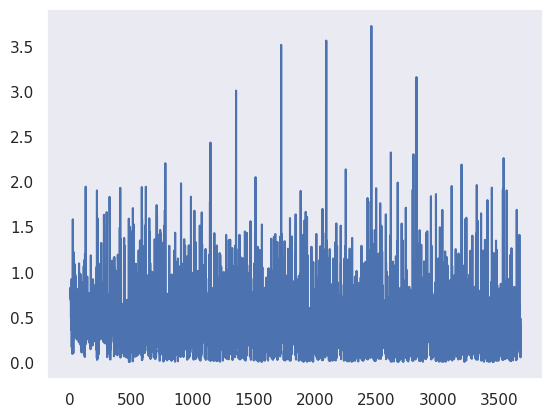

In [14]:
plt.plot(train_losses)

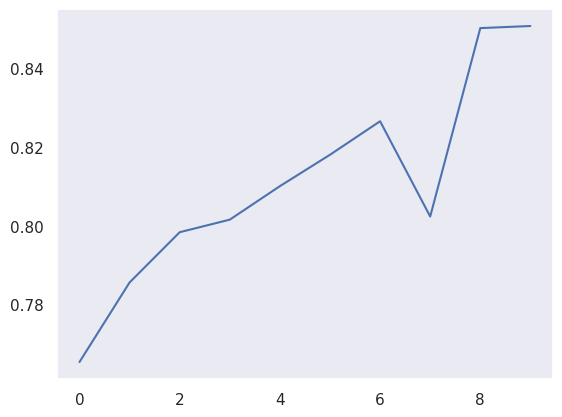

In [15]:
plt.plot(test_accuracy)

In [16]:
model_path = '../physio16k_fold1_m13mfcc_10epochs.pt' 
torch.save(model.state_dict(), model_path)

In [17]:
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, 
    MulticlassRecall, MulticlassF1Score, 
    MulticlassConfusionMatrix,
    MulticlassAUROC
)
from torchmetrics import MetricCollection
from torchmetrics.wrappers import ClasswiseWrapper
from pprint import pprint

@torch.no_grad
def report_metrics(model, labels=labels):
    n = len(labels)
    metrics = MetricCollection({
        'acc_unweighted': MulticlassAccuracy(num_classes=n, average='macro'), 
        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        
        'f1s_unweighted': MulticlassF1Score(num_classes=n, average='macro'),  
        'f1s_weighted': MulticlassF1Score(num_classes=n, average='weighted'),  

        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        'uar': MulticlassRecall(num_classes=n, average='macro'), 
        'wap': MulticlassPrecision(num_classes=n, average='weighted'),
        'rocauc': MulticlassAUROC(num_classes=n, average='macro', thresholds=None),    
        'f1s_detail': MulticlassF1Score(num_classes=n, average=None),  
        'acc_detail': MulticlassAccuracy(num_classes=n, average=None), 
        'precision_detail': MulticlassPrecision(num_classes=n, average=None),
        'recall_detail': MulticlassRecall(num_classes=n, average=None), 
        'rocauc_detail': MulticlassAUROC(num_classes=n, average=None, thresholds=None),
    }).to(device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=n).to(device)
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        
        metrics.update(probs, target)
        confusion_matrix.update(pred, target)
        
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    print(f'Correct: {correct}/{total} ({correct/total:.4f})')
    return metrics, confusion_matrix

In [18]:
metrics, confusion_matrix = report_metrics(model)
pprint(metrics.compute())
confusion_matrix.compute()

Correct: 3206/3744 (0.8563)
{'acc_detail': tensor([0.5583, 0.9449], device='cuda:0'),
 'acc_unweighted': tensor(0.7516, device='cuda:0'),
 'acc_weighted': tensor(0.8563, device='cuda:0'),
 'f1s_detail': tensor([0.6404, 0.9102], device='cuda:0'),
 'f1s_unweighted': tensor(0.7753, device='cuda:0'),
 'f1s_weighted': tensor(0.8484, device='cuda:0'),
 'precision_detail': tensor([0.7508, 0.8780], device='cuda:0'),
 'recall_detail': tensor([0.5583, 0.9449], device='cuda:0'),
 'rocauc': tensor(0.9272, device='cuda:0'),
 'rocauc_detail': tensor([0.9272, 0.9272], device='cuda:0'),
 'uar': tensor(0.7516, device='cuda:0'),
 'wap': tensor(0.8488, device='cuda:0')}


tensor([[ 479,  379],
        [ 159, 2727]], device='cuda:0')

In [19]:
n_epoch = 10
n_epoch2 = 50
# train_losses = []
# test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.05,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)

log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1+n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                                                                                        | 0.004123711340206186/50 [00:00<1:21:00, 97.23s/it]

Train Epoch: 11 [0/11805 (0%)]	Loss: 1.149708
Mem before-during-after: 17883648 18029568 18506240


  0%|▏                                                                                                        | 0.08453608247422686/50 [00:07<1:16:31, 91.98s/it]

Train Epoch: 11 [1280/11805 (11%)]	Loss: 0.003846
Mem before-during-after: 18506240 18651136 18506240


  0%|▎                                                                                                        | 0.16907216494845365/50 [00:15<1:16:58, 92.67s/it]

Train Epoch: 11 [2560/11805 (22%)]	Loss: 0.125523
Mem before-during-after: 18506240 18651136 18506240


  1%|▌                                                                                                         | 0.2515463917525771/50 [00:23<1:17:42, 93.72s/it]

Train Epoch: 11 [3840/11805 (33%)]	Loss: 0.051923
Mem before-during-after: 18506240 18651136 18506240


  1%|▋                                                                                                         | 0.3340206185567005/50 [00:31<1:16:00, 91.82s/it]

Train Epoch: 11 [5120/11805 (43%)]	Loss: 0.035088
Mem before-during-after: 18506240 18651136 18506240


  1%|▊                                                                                                        | 0.41649484536082393/50 [00:39<1:14:50, 90.57s/it]

Train Epoch: 11 [6400/11805 (54%)]	Loss: 1.088241
Mem before-during-after: 18506240 18651136 18506240


  1%|█                                                                                                        | 0.49896907216494735/50 [00:46<1:17:36, 94.06s/it]

Train Epoch: 11 [7680/11805 (65%)]	Loss: 0.334045
Mem before-during-after: 18506240 18651136 18506240


  1%|█▏                                                                                                        | 0.5814432989690708/50 [00:54<1:16:08, 92.45s/it]

Train Epoch: 11 [8960/11805 (76%)]	Loss: 0.487416
Mem before-during-after: 18506240 18651136 18506240


  1%|█▍                                                                                                        | 0.6618556701030911/50 [01:02<1:16:00, 92.43s/it]

Train Epoch: 11 [10240/11805 (87%)]	Loss: 0.080040
Mem before-during-after: 18506240 18651136 18506240


  1%|█▌                                                                                                        | 0.7463917525773176/50 [01:10<1:14:20, 90.57s/it]

Train Epoch: 11 [11520/11805 (98%)]	Loss: 0.415528
Mem before-during-after: 18506240 18651136 18506240


  2%|██                                                                                                        | 1.0020618556701002/50 [01:33<1:15:47, 92.80s/it]


Test Epoch: 11	Accuracy: 3287/3744 (87%)

Train Epoch: 12 [0/11805 (0%)]	Loss: 0.545153
Mem before-during-after: 18505216 18651136 18506240


  2%|██▎                                                                                                       | 1.0865979381443267/50 [01:41<1:15:38, 92.78s/it]

Train Epoch: 12 [1280/11805 (11%)]	Loss: 0.014242
Mem before-during-after: 18506240 18651136 18506240


  2%|██▍                                                                                                       | 1.1690721649484501/50 [01:49<1:16:42, 94.26s/it]

Train Epoch: 12 [2560/11805 (22%)]	Loss: 0.119010
Mem before-during-after: 18506240 18651136 18506240


  3%|██▋                                                                                                       | 1.2515463917525735/50 [01:57<1:17:59, 95.99s/it]

Train Epoch: 12 [3840/11805 (33%)]	Loss: 0.041007
Mem before-during-after: 18506240 18651136 18506240


  3%|██▊                                                                                                        | 1.334020618556697/50 [02:05<1:14:29, 91.84s/it]

Train Epoch: 12 [5120/11805 (43%)]	Loss: 0.046083
Mem before-during-after: 18506240 18651136 18506240


  3%|███                                                                                                       | 1.4164948453608204/50 [02:12<1:16:52, 94.94s/it]

Train Epoch: 12 [6400/11805 (54%)]	Loss: 0.943115
Mem before-during-after: 18506240 18651136 18506240


  3%|███▏                                                                                                      | 1.4989690721649438/50 [02:20<1:15:18, 93.17s/it]

Train Epoch: 12 [7680/11805 (65%)]	Loss: 0.322095
Mem before-during-after: 18506240 18651136 18506240


  3%|███▎                                                                                                      | 1.5793814432989641/50 [02:28<1:14:54, 92.81s/it]

Train Epoch: 12 [8960/11805 (76%)]	Loss: 0.720845
Mem before-during-after: 18506240 18651136 18506240


  3%|███▌                                                                                                      | 1.6639175257731906/50 [02:36<1:15:30, 93.73s/it]

Train Epoch: 12 [10240/11805 (87%)]	Loss: 0.078021
Mem before-during-after: 18506240 18651136 18506240


  3%|███▋                                                                                                       | 1.746391752577314/50 [02:43<1:13:07, 90.92s/it]

Train Epoch: 12 [11520/11805 (98%)]	Loss: 0.464410
Mem before-during-after: 18506240 18651136 18506240


  4%|████▎                                                                                                      | 2.002061855670097/50 [03:07<1:12:42, 90.88s/it]


Test Epoch: 12	Accuracy: 3277/3744 (87%)

Train Epoch: 13 [0/11805 (0%)]	Loss: 0.495990
Mem before-during-after: 18505216 18651136 18506240


  4%|████▍                                                                                                     | 2.0865979381443234/50 [03:15<1:14:00, 92.68s/it]

Train Epoch: 13 [1280/11805 (11%)]	Loss: 0.024833
Mem before-during-after: 18506240 18651136 18506240


  4%|████▌                                                                                                     | 2.1670103092783437/50 [03:22<1:11:39, 89.88s/it]

Train Epoch: 13 [2560/11805 (22%)]	Loss: 0.139712
Mem before-during-after: 18506240 18651136 18506240


  5%|████▊                                                                                                       | 2.25154639175257/50 [03:30<1:13:15, 92.06s/it]

Train Epoch: 13 [3840/11805 (33%)]	Loss: 0.026785
Mem before-during-after: 18506240 18651136 18506240


  5%|████▉                                                                                                     | 2.3340206185566936/50 [03:38<1:13:23, 92.39s/it]

Train Epoch: 13 [5120/11805 (43%)]	Loss: 0.040567
Mem before-during-after: 18506240 18651136 18506240


  5%|█████▏                                                                                                     | 2.416494845360817/50 [03:46<1:14:37, 94.09s/it]

Train Epoch: 13 [6400/11805 (54%)]	Loss: 1.010884
Mem before-during-after: 18506240 18651136 18506240


  5%|█████▎                                                                                                    | 2.4989690721649405/50 [03:53<1:12:08, 91.12s/it]

Train Epoch: 13 [7680/11805 (65%)]	Loss: 0.383301
Mem before-during-after: 18506240 18651136 18506240


  5%|█████▌                                                                                                     | 2.581443298969064/50 [04:01<1:11:48, 90.86s/it]

Train Epoch: 13 [8960/11805 (76%)]	Loss: 0.812812
Mem before-during-after: 18506240 18651136 18506240


  5%|█████▋                                                                                                    | 2.6639175257731873/50 [04:09<1:11:35, 90.75s/it]

Train Epoch: 13 [10240/11805 (87%)]	Loss: 0.069242
Mem before-during-after: 18506240 18651136 18506240


  5%|█████▊                                                                                                    | 2.7463917525773107/50 [04:16<1:12:57, 92.63s/it]

Train Epoch: 13 [11520/11805 (98%)]	Loss: 0.463615
Mem before-during-after: 18506240 18651136 18506240


  6%|██████▎                                                                                                   | 2.9999999999999902/50 [04:40<1:11:24, 91.16s/it]


Test Epoch: 13	Accuracy: 3248/3744 (86%)



  6%|██████▎                                                                                                   | 3.0041237113401964/50 [04:40<1:13:05, 93.32s/it]

Train Epoch: 14 [0/11805 (0%)]	Loss: 0.560418
Mem before-during-after: 18505216 18651136 18506240


  6%|██████▋                                                                                                     | 3.08659793814432/50 [04:48<1:12:45, 93.05s/it]

Train Epoch: 14 [1280/11805 (11%)]	Loss: 0.020596
Mem before-during-after: 18506240 18651136 18506240


  6%|██████▊                                                                                                     | 3.16701030927834/50 [04:55<1:11:58, 92.20s/it]

Train Epoch: 14 [2560/11805 (22%)]	Loss: 0.130713
Mem before-during-after: 18506240 18651136 18506240


  6%|██████▉                                                                                                   | 3.2494845360824636/50 [05:03<1:10:13, 90.13s/it]

Train Epoch: 14 [3840/11805 (33%)]	Loss: 0.013342
Mem before-during-after: 18506240 18651136 18506240


  7%|███████▏                                                                                                    | 3.33402061855669/50 [05:11<1:12:26, 93.13s/it]

Train Epoch: 14 [5120/11805 (43%)]	Loss: 0.054350
Mem before-during-after: 18506240 18651136 18506240


  7%|███████▏                                                                                                  | 3.4164948453608135/50 [05:18<1:12:16, 93.09s/it]

Train Epoch: 14 [6400/11805 (54%)]	Loss: 1.033424
Mem before-during-after: 18506240 18651136 18506240


  7%|███████▍                                                                                                   | 3.498969072164937/50 [05:26<1:10:54, 91.50s/it]

Train Epoch: 14 [7680/11805 (65%)]	Loss: 0.459191
Mem before-during-after: 18506240 18651136 18506240


  7%|███████▌                                                                                                  | 3.5814432989690603/50 [05:34<1:11:34, 92.52s/it]

Train Epoch: 14 [8960/11805 (76%)]	Loss: 1.034627
Mem before-during-after: 18506240 18651136 18506240


  7%|███████▊                                                                                                  | 3.6639175257731837/50 [05:41<1:10:59, 91.93s/it]

Train Epoch: 14 [10240/11805 (87%)]	Loss: 0.068950
Mem before-during-after: 18506240 18651136 18506240


  7%|████████                                                                                                   | 3.746391752577307/50 [05:49<1:10:55, 92.01s/it]

Train Epoch: 14 [11520/11805 (98%)]	Loss: 0.480017
Mem before-during-after: 18506240 18651136 18506240


  8%|████████▋                                                                                                   | 4.00206185567009/50 [06:13<1:09:09, 90.21s/it]


Test Epoch: 14	Accuracy: 3289/3744 (87%)

Train Epoch: 15 [0/11805 (0%)]	Loss: 0.505196
Mem before-during-after: 18505216 18651136 18506240


  8%|████████▋                                                                                                  | 4.086597938144316/50 [06:21<1:12:58, 95.37s/it]

Train Epoch: 15 [1280/11805 (11%)]	Loss: 0.026145
Mem before-during-after: 18506240 18651136 18506240


  8%|█████████                                                                                                   | 4.16907216494844/50 [06:28<1:11:39, 93.80s/it]

Train Epoch: 15 [2560/11805 (22%)]	Loss: 0.087946
Mem before-during-after: 18506240 18651136 18506240


  9%|█████████                                                                                                  | 4.251546391752563/50 [06:36<1:08:32, 89.88s/it]

Train Epoch: 15 [3840/11805 (33%)]	Loss: 0.007033
Mem before-during-after: 18506240 18651136 18506240


  9%|█████████▎                                                                                                 | 4.331958762886583/50 [06:43<1:09:04, 90.75s/it]

Train Epoch: 15 [5120/11805 (43%)]	Loss: 0.041245
Mem before-during-after: 18506240 18651136 18506240


  9%|█████████▌                                                                                                  | 4.41649484536081/50 [06:51<1:09:33, 91.56s/it]

Train Epoch: 15 [6400/11805 (54%)]	Loss: 1.093928
Mem before-during-after: 18506240 18651136 18506240


  9%|█████████▋                                                                                                 | 4.498969072164933/50 [06:59<1:09:03, 91.06s/it]

Train Epoch: 15 [7680/11805 (65%)]	Loss: 0.381628
Mem before-during-after: 18506240 18651136 18506240


  9%|█████████▊                                                                                                 | 4.581443298969057/50 [07:07<1:09:08, 91.33s/it]

Train Epoch: 15 [8960/11805 (76%)]	Loss: 1.213073
Mem before-during-after: 18506240 18651136 18506240


  9%|██████████                                                                                                  | 4.66391752577318/50 [07:14<1:09:13, 91.61s/it]

Train Epoch: 15 [10240/11805 (87%)]	Loss: 0.072925
Mem before-during-after: 18506240 18651136 18506240


  9%|██████████▏                                                                                                | 4.746391752577304/50 [07:22<1:08:51, 91.29s/it]

Train Epoch: 15 [11520/11805 (98%)]	Loss: 0.498218
Mem before-during-after: 18506240 18651136 18506240


 10%|██████████▋                                                                                                | 4.999999999999983/50 [07:45<1:06:37, 88.84s/it]


Test Epoch: 15	Accuracy: 3279/3744 (87%)



 10%|██████████▋                                                                                                | 5.004123711340189/50 [07:46<1:09:12, 92.28s/it]

Train Epoch: 16 [0/11805 (0%)]	Loss: 0.474313
Mem before-during-after: 18505216 18651136 18506240


 10%|██████████▉                                                                                                 | 5.08453608247421/50 [07:53<1:09:03, 92.25s/it]

Train Epoch: 16 [1280/11805 (11%)]	Loss: 0.023970
Mem before-during-after: 18506240 18651136 18506240


 10%|███████████                                                                                                | 5.169072164948436/50 [08:01<1:09:09, 92.56s/it]

Train Epoch: 16 [2560/11805 (22%)]	Loss: 0.084866
Mem before-during-after: 18506240 18651136 18506240


 10%|███████████▏                                                                                              | 5.2494845360824565/50 [08:09<1:08:34, 91.94s/it]

Train Epoch: 16 [3840/11805 (33%)]	Loss: 0.003896
Mem before-during-after: 18506240 18651136 18506240


 11%|███████████▍                                                                                               | 5.334020618556683/50 [08:17<1:12:41, 97.64s/it]

Train Epoch: 16 [5120/11805 (43%)]	Loss: 0.053924
Mem before-during-after: 18506240 18651136 18506240


 11%|███████████▌                                                                                               | 5.416494845360806/50 [08:24<1:09:24, 93.41s/it]

Train Epoch: 16 [6400/11805 (54%)]	Loss: 1.135633
Mem before-during-after: 18506240 18651136 18506240


 11%|███████████▊                                                                                               | 5.496907216494827/50 [08:32<1:07:55, 91.57s/it]

Train Epoch: 16 [7680/11805 (65%)]	Loss: 0.413336
Mem before-during-after: 18506240 18651136 18506240


 11%|███████████▉                                                                                               | 5.581443298969053/50 [08:40<1:07:46, 91.56s/it]

Train Epoch: 16 [8960/11805 (76%)]	Loss: 1.215623
Mem before-during-after: 18506240 18651136 18506240


 11%|████████████                                                                                               | 5.663917525773177/50 [08:47<1:08:36, 92.84s/it]

Train Epoch: 16 [10240/11805 (87%)]	Loss: 0.077684
Mem before-during-after: 18506240 18651136 18506240


 11%|████████████▌                                                                                                | 5.7463917525773/50 [08:55<1:09:37, 94.41s/it]

Train Epoch: 16 [11520/11805 (98%)]	Loss: 0.446673
Mem before-during-after: 18506240 18651136 18506240


 12%|████████████▊                                                                                              | 6.002061855670083/50 [09:19<1:08:31, 93.46s/it]


Test Epoch: 16	Accuracy: 3315/3744 (88%)

Train Epoch: 17 [0/11805 (0%)]	Loss: 0.532527
Mem before-during-after: 18505216 18651136 18506240


 12%|█████████████                                                                                              | 6.086597938144309/50 [09:27<1:07:32, 92.29s/it]

Train Epoch: 17 [1280/11805 (11%)]	Loss: 0.033100
Mem before-during-after: 18506240 18651136 18506240


 12%|█████████████▏                                                                                             | 6.169072164948433/50 [09:35<1:09:20, 94.92s/it]

Train Epoch: 17 [2560/11805 (22%)]	Loss: 0.104143
Mem before-during-after: 18506240 18651136 18506240


 13%|█████████████▍                                                                                             | 6.251546391752556/50 [09:43<1:08:03, 93.34s/it]

Train Epoch: 17 [3840/11805 (33%)]	Loss: 0.003724
Mem before-during-after: 18506240 18651136 18506240


 13%|█████████████▌                                                                                             | 6.334020618556679/50 [09:51<1:07:59, 93.43s/it]

Train Epoch: 17 [5120/11805 (43%)]	Loss: 0.064150
Mem before-during-after: 18506240 18651136 18506240


 13%|█████████████▋                                                                                             | 6.416494845360803/50 [09:58<1:07:15, 92.60s/it]

Train Epoch: 17 [6400/11805 (54%)]	Loss: 1.191870
Mem before-during-after: 18506240 18651136 18506240


 13%|█████████████▉                                                                                             | 6.498969072164926/50 [10:06<1:08:24, 94.36s/it]

Train Epoch: 17 [7680/11805 (65%)]	Loss: 0.392704
Mem before-during-after: 18506240 18651136 18506240


 13%|██████████████▏                                                                                             | 6.58144329896905/50 [10:14<1:08:39, 94.89s/it]

Train Epoch: 17 [8960/11805 (76%)]	Loss: 1.517016
Mem before-during-after: 18506240 18651136 18506240


 13%|██████████████▎                                                                                            | 6.663917525773173/50 [10:22<1:07:56, 94.08s/it]

Train Epoch: 17 [10240/11805 (87%)]	Loss: 0.065188
Mem before-during-after: 18506240 18651136 18506240


 13%|██████████████▎                                                                                           | 6.7463917525772965/50 [10:29<1:07:50, 94.11s/it]

Train Epoch: 17 [11520/11805 (98%)]	Loss: 0.445837
Mem before-during-after: 18506240 18651136 18506240


 14%|██████████████▉                                                                                            | 7.002061855670079/50 [10:53<1:07:06, 93.64s/it]


Test Epoch: 17	Accuracy: 3288/3744 (87%)

Train Epoch: 18 [0/11805 (0%)]	Loss: 0.422501
Mem before-during-after: 18505216 18651136 18506240


 14%|███████████████▏                                                                                           | 7.086597938144306/50 [11:01<1:06:50, 93.46s/it]

Train Epoch: 18 [1280/11805 (11%)]	Loss: 0.033704
Mem before-during-after: 18506240 18651136 18506240


 14%|███████████████▎                                                                                           | 7.167010309278326/50 [11:09<1:05:50, 92.23s/it]

Train Epoch: 18 [2560/11805 (22%)]	Loss: 0.092406
Mem before-during-after: 18506240 18651136 18506240


 15%|███████████████▎                                                                                          | 7.2515463917525524/50 [11:16<1:05:12, 91.53s/it]

Train Epoch: 18 [3840/11805 (33%)]	Loss: 0.008651
Mem before-during-after: 18506240 18651136 18506240


 15%|███████████████▋                                                                                           | 7.334020618556676/50 [11:24<1:07:05, 94.34s/it]

Train Epoch: 18 [5120/11805 (43%)]	Loss: 0.046098
Mem before-during-after: 18506240 18651136 18506240


 15%|███████████████▊                                                                                           | 7.416494845360799/50 [11:32<1:06:33, 93.79s/it]

Train Epoch: 18 [6400/11805 (54%)]	Loss: 1.188134
Mem before-during-after: 18506240 18651136 18506240


 15%|████████████████▏                                                                                           | 7.49690721649482/50 [11:40<1:06:55, 94.48s/it]

Train Epoch: 18 [7680/11805 (65%)]	Loss: 0.418729
Mem before-during-after: 18506240 18651136 18506240


 15%|████████████████▏                                                                                          | 7.581443298969046/50 [11:48<1:06:51, 94.56s/it]

Train Epoch: 18 [8960/11805 (76%)]	Loss: 1.622906
Mem before-during-after: 18506240 18651136 18506240


 15%|████████████████▏                                                                                         | 7.6639175257731695/50 [11:55<1:05:39, 93.06s/it]

Train Epoch: 18 [10240/11805 (87%)]	Loss: 0.070020
Mem before-during-after: 18506240 18651136 18506240


 15%|████████████████▋                                                                                           | 7.74432989690719/50 [12:03<1:05:35, 93.14s/it]

Train Epoch: 18 [11520/11805 (98%)]	Loss: 0.409676
Mem before-during-after: 18506240 18651136 18506240


 16%|█████████████████                                                                                          | 8.002061855670076/50 [12:27<1:04:37, 92.33s/it]


Test Epoch: 18	Accuracy: 3333/3744 (88%)

Train Epoch: 19 [0/11805 (0%)]	Loss: 0.450617
Mem before-during-after: 18505216 18651136 18506240


 16%|█████████████████▎                                                                                         | 8.086597938144303/50 [12:35<1:08:02, 97.40s/it]

Train Epoch: 19 [1280/11805 (11%)]	Loss: 0.027202
Mem before-during-after: 18506240 18651136 18506240


 16%|█████████████████▍                                                                                         | 8.169072164948426/50 [12:42<1:02:32, 89.71s/it]

Train Epoch: 19 [2560/11805 (22%)]	Loss: 0.136241
Mem before-during-after: 18506240 18651136 18506240


 17%|█████████████████▊                                                                                          | 8.25154639175255/50 [12:50<1:05:10, 93.68s/it]

Train Epoch: 19 [3840/11805 (33%)]	Loss: 0.018328
Mem before-during-after: 18506240 18651136 18506240


 17%|█████████████████▉                                                                                          | 8.33195876288657/50 [12:58<1:03:56, 92.07s/it]

Train Epoch: 19 [5120/11805 (43%)]	Loss: 0.038302
Mem before-during-after: 18506240 18651136 18506240


 17%|██████████████████                                                                                         | 8.416494845360797/50 [13:06<1:03:57, 92.29s/it]

Train Epoch: 19 [6400/11805 (54%)]	Loss: 1.122661
Mem before-during-after: 18506240 18651136 18506240


 17%|██████████████████▎                                                                                         | 8.49896907216492/50 [13:13<1:03:45, 92.17s/it]

Train Epoch: 19 [7680/11805 (65%)]	Loss: 0.471595
Mem before-during-after: 18506240 18651136 18506240


 17%|██████████████████▎                                                                                        | 8.581443298969043/50 [13:21<1:05:04, 94.27s/it]

Train Epoch: 19 [8960/11805 (76%)]	Loss: 1.754467
Mem before-during-after: 18506240 18651136 18506240


 17%|██████████████████▌                                                                                        | 8.661855670103064/50 [13:29<1:03:57, 92.84s/it]

Train Epoch: 19 [10240/11805 (87%)]	Loss: 0.090897
Mem before-during-after: 18506240 18651136 18506240


 17%|██████████████████▋                                                                                        | 8.744329896907187/50 [13:36<1:04:49, 94.27s/it]

Train Epoch: 19 [11520/11805 (98%)]	Loss: 0.401802
Mem before-during-after: 18506240 18651136 18506240


 18%|███████████████████▎                                                                                       | 9.002061855670073/50 [14:00<1:05:05, 95.27s/it]


Test Epoch: 19	Accuracy: 3329/3744 (88%)

Train Epoch: 20 [0/11805 (0%)]	Loss: 0.447161
Mem before-during-after: 18505216 18651136 18506240


 18%|███████████████████▊                                                                                         | 9.0865979381443/50 [14:08<1:03:54, 93.73s/it]

Train Epoch: 20 [1280/11805 (11%)]	Loss: 0.040413
Mem before-during-after: 18506240 18651136 18506240


 18%|███████████████████▌                                                                                       | 9.169072164948423/50 [14:16<1:03:31, 93.35s/it]

Train Epoch: 20 [2560/11805 (22%)]	Loss: 0.119379
Mem before-during-after: 18506240 18651136 18506240


 19%|███████████████████▊                                                                                       | 9.251546391752546/50 [14:24<1:03:51, 94.02s/it]

Train Epoch: 20 [3840/11805 (33%)]	Loss: 0.041401
Mem before-during-after: 18506240 18651136 18506240


 19%|███████████████████▉                                                                                       | 9.331958762886567/50 [14:31<1:02:47, 92.63s/it]

Train Epoch: 20 [5120/11805 (43%)]	Loss: 0.054769
Mem before-during-after: 18506240 18651136 18506240


 19%|████████████████████▏                                                                                      | 9.416494845360793/50 [14:39<1:02:21, 92.18s/it]

Train Epoch: 20 [6400/11805 (54%)]	Loss: 1.157558
Mem before-during-after: 18506240 18651136 18506240


 19%|████████████████████▎                                                                                      | 9.498969072164916/50 [14:47<1:02:53, 93.17s/it]

Train Epoch: 20 [7680/11805 (65%)]	Loss: 0.597677
Mem before-during-after: 18506240 18651136 18506240


 19%|████████████████████▋                                                                                       | 9.58144329896904/50 [14:55<1:02:38, 93.00s/it]

Train Epoch: 20 [8960/11805 (76%)]	Loss: 1.883755
Mem before-during-after: 18506240 18651136 18506240


 19%|████████████████████▋                                                                                      | 9.663917525773163/50 [15:03<1:03:26, 94.36s/it]

Train Epoch: 20 [10240/11805 (87%)]	Loss: 0.095632
Mem before-during-after: 18506240 18651136 18506240


 19%|████████████████████▊                                                                                      | 9.746391752577287/50 [15:10<1:04:30, 96.16s/it]

Train Epoch: 20 [11520/11805 (98%)]	Loss: 0.428338
Mem before-during-after: 18506240 18651136 18506240


 20%|█████████████████████▍                                                                                     | 9.999999999999966/50 [15:34<1:01:20, 92.00s/it]


Test Epoch: 20	Accuracy: 3304/3744 (88%)



 20%|█████████████████████▍                                                                                     | 10.00206185567007/50 [15:34<1:02:32, 93.81s/it]

Train Epoch: 21 [0/11805 (0%)]	Loss: 0.506362
Mem before-during-after: 18505216 18651136 18506240


 20%|█████████████████████▍                                                                                    | 10.086597938144296/50 [15:42<1:04:48, 97.43s/it]

Train Epoch: 21 [1280/11805 (11%)]	Loss: 0.022870
Mem before-during-after: 18506240 18651136 18506240


 20%|█████████████████████▊                                                                                     | 10.16907216494842/50 [15:50<1:01:53, 93.23s/it]

Train Epoch: 21 [2560/11805 (22%)]	Loss: 0.157280
Mem before-during-after: 18506240 18651136 18506240


 20%|█████████████████████▉                                                                                     | 10.24948453608244/50 [15:58<1:01:24, 92.70s/it]

Train Epoch: 21 [3840/11805 (33%)]	Loss: 0.165364
Mem before-during-after: 18506240 18651136 18506240


 21%|█████████████████████▉                                                                                    | 10.334020618556666/50 [16:06<1:01:32, 93.09s/it]

Train Epoch: 21 [5120/11805 (43%)]	Loss: 0.047722
Mem before-during-after: 18506240 18651136 18506240


 21%|██████████████████████                                                                                    | 10.414432989690686/50 [16:13<1:02:17, 94.42s/it]

Train Epoch: 21 [6400/11805 (54%)]	Loss: 1.142837
Mem before-during-after: 18506240 18651136 18506240


 21%|██████████████████████▎                                                                                   | 10.498969072164913/50 [16:21<1:00:30, 91.90s/it]

Train Epoch: 21 [7680/11805 (65%)]	Loss: 0.576260
Mem before-during-after: 18506240 18651136 18506240


 21%|██████████████████████▍                                                                                   | 10.579381443298933/50 [16:29<1:02:04, 94.48s/it]

Train Epoch: 21 [8960/11805 (76%)]	Loss: 1.712366
Mem before-during-after: 18506240 18651136 18506240


 21%|███████████████████████▏                                                                                     | 10.66391752577316/50 [16:37<59:15, 90.38s/it]

Train Epoch: 21 [10240/11805 (87%)]	Loss: 0.084097
Mem before-during-after: 18506240 18651136 18506240


 21%|██████████████████████▊                                                                                   | 10.746391752577283/50 [16:44<1:00:06, 91.88s/it]

Train Epoch: 21 [11520/11805 (98%)]	Loss: 0.436353
Mem before-during-after: 18506240 18651136 18506240


 22%|███████████████████████▊                                                                                    | 10.999999999999963/50 [17:08<58:24, 89.86s/it]


Test Epoch: 21	Accuracy: 3325/3744 (88%)



 22%|███████████████████████▎                                                                                  | 11.004123711340169/50 [17:09<1:02:01, 95.42s/it]

Train Epoch: 22 [0/11805 (0%)]	Loss: 0.427248
Mem before-during-after: 18505216 18651136 18506240


 22%|████████████████████████▏                                                                                    | 11.08453608247419/50 [17:16<58:34, 90.30s/it]

Train Epoch: 22 [1280/11805 (11%)]	Loss: 0.017373
Mem before-during-after: 18506240 18651136 18506240


 22%|███████████████████████▋                                                                                  | 11.167010309278313/50 [17:24<1:01:04, 94.37s/it]

Train Epoch: 22 [2560/11805 (22%)]	Loss: 0.162534
Mem before-during-after: 18506240 18651136 18506240


 23%|████████████████████████▌                                                                                    | 11.25154639175254/50 [17:32<59:30, 92.15s/it]

Train Epoch: 22 [3840/11805 (33%)]	Loss: 0.070771
Mem before-during-after: 18506240 18651136 18506240


 23%|████████████████████████                                                                                  | 11.334020618556663/50 [17:40<1:00:07, 93.29s/it]

Train Epoch: 22 [5120/11805 (43%)]	Loss: 0.039906
Mem before-during-after: 18506240 18651136 18506240


 23%|████████████████████████▋                                                                                   | 11.414432989690683/50 [17:47<59:11, 92.03s/it]

Train Epoch: 22 [6400/11805 (54%)]	Loss: 1.235941
Mem before-during-after: 18506240 18651136 18506240


 23%|████████████████████████▌                                                                                  | 11.49896907216491/50 [17:55<1:00:02, 93.57s/it]

Train Epoch: 22 [7680/11805 (65%)]	Loss: 0.445992
Mem before-during-after: 18506240 18651136 18506240


 23%|█████████████████████████▏                                                                                   | 11.57938144329893/50 [18:03<58:13, 90.92s/it]

Train Epoch: 22 [8960/11805 (76%)]	Loss: 1.914729
Mem before-during-after: 18506240 18651136 18506240


 23%|█████████████████████████▏                                                                                  | 11.663917525773156/50 [18:11<59:17, 92.79s/it]

Train Epoch: 22 [10240/11805 (87%)]	Loss: 0.116530
Mem before-during-after: 18506240 18651136 18506240


 23%|█████████████████████████▎                                                                                  | 11.744329896907177/50 [18:18<58:34, 91.87s/it]

Train Epoch: 22 [11520/11805 (98%)]	Loss: 0.399159
Mem before-during-after: 18506240 18651136 18506240


 24%|██████████████████████████▏                                                                                  | 11.99999999999996/50 [18:42<57:11, 90.29s/it]


Test Epoch: 22	Accuracy: 3315/3744 (88%)



 24%|█████████████████████████▍                                                                                | 12.002061855670062/50 [18:42<1:00:29, 95.53s/it]

Train Epoch: 23 [0/11805 (0%)]	Loss: 0.434910
Mem before-during-after: 18505216 18651136 18506240


 24%|██████████████████████████                                                                                  | 12.086597938144289/50 [18:50<59:19, 93.87s/it]

Train Epoch: 23 [1280/11805 (11%)]	Loss: 0.023111
Mem before-during-after: 18506240 18651136 18506240


 24%|██████████████████████████▎                                                                                 | 12.167010309278309/50 [18:57<57:26, 91.11s/it]

Train Epoch: 23 [2560/11805 (22%)]	Loss: 0.207850
Mem before-during-after: 18506240 18651136 18506240


 25%|██████████████████████████▍                                                                                 | 12.251546391752536/50 [19:05<59:24, 94.43s/it]

Train Epoch: 23 [3840/11805 (33%)]	Loss: 0.084010
Mem before-during-after: 18506240 18651136 18506240


 25%|██████████████████████████▋                                                                                 | 12.334020618556659/50 [19:13<58:07, 92.59s/it]

Train Epoch: 23 [5120/11805 (43%)]	Loss: 0.033691
Mem before-during-after: 18506240 18651136 18506240


 25%|██████████████████████████▎                                                                               | 12.416494845360782/50 [19:21<1:02:08, 99.20s/it]

Train Epoch: 23 [6400/11805 (54%)]	Loss: 1.115254
Mem before-during-after: 18506240 18651136 18506240


 25%|██████████████████████████▉                                                                                 | 12.498969072164906/50 [19:29<59:21, 94.98s/it]

Train Epoch: 23 [7680/11805 (65%)]	Loss: 0.467269
Mem before-during-after: 18506240 18651136 18506240


 25%|███████████████████████████▏                                                                                | 12.579381443298926/50 [19:36<56:45, 91.00s/it]

Train Epoch: 23 [8960/11805 (76%)]	Loss: 1.621880
Mem before-during-after: 18506240 18651136 18506240


 25%|███████████████████████████▎                                                                                | 12.663917525773153/50 [19:44<56:58, 91.57s/it]

Train Epoch: 23 [10240/11805 (87%)]	Loss: 0.075981
Mem before-during-after: 18506240 18651136 18506240


 25%|███████████████████████████▌                                                                                | 12.746391752577276/50 [19:52<57:30, 92.62s/it]

Train Epoch: 23 [11520/11805 (98%)]	Loss: 0.415430
Mem before-during-after: 18506240 18651136 18506240


 26%|████████████████████████████                                                                                | 13.002061855670059/50 [20:16<56:38, 91.85s/it]


Test Epoch: 23	Accuracy: 3340/3744 (89%)

Train Epoch: 24 [0/11805 (0%)]	Loss: 0.401084
Mem before-during-after: 18505216 18651136 18506240


 26%|████████████████████████████▎                                                                               | 13.086597938144285/50 [20:24<56:14, 91.41s/it]

Train Epoch: 24 [1280/11805 (11%)]	Loss: 0.017796
Mem before-during-after: 18506240 18651136 18506240


 26%|████████████████████████████▍                                                                               | 13.169072164948409/50 [20:32<56:47, 92.51s/it]

Train Epoch: 24 [2560/11805 (22%)]	Loss: 0.181106
Mem before-during-after: 18506240 18651136 18506240


 27%|████████████████████████████▌                                                                               | 13.251546391752532/50 [20:39<57:52, 94.50s/it]

Train Epoch: 24 [3840/11805 (33%)]	Loss: 0.048773
Mem before-during-after: 18506240 18651136 18506240


 27%|████████████████████████████▊                                                                               | 13.334020618556655/50 [20:47<55:47, 91.29s/it]

Train Epoch: 24 [5120/11805 (43%)]	Loss: 0.038008
Mem before-during-after: 18506240 18651136 18506240


 27%|████████████████████████████▉                                                                               | 13.416494845360779/50 [20:55<56:44, 93.06s/it]

Train Epoch: 24 [6400/11805 (54%)]	Loss: 1.037932
Mem before-during-after: 18506240 18651136 18506240


 27%|█████████████████████████████▏                                                                              | 13.4969072164948/50 [21:03<1:00:25, 99.31s/it]

Train Epoch: 24 [7680/11805 (65%)]	Loss: 0.413645
Mem before-during-after: 18506240 18651136 18506240


 27%|█████████████████████████████▎                                                                              | 13.579381443298923/50 [21:10<56:15, 92.69s/it]

Train Epoch: 24 [8960/11805 (76%)]	Loss: 1.590646
Mem before-during-after: 18506240 18651136 18506240


 27%|█████████████████████████████▌                                                                              | 13.663917525773149/50 [21:18<57:01, 94.16s/it]

Train Epoch: 24 [10240/11805 (87%)]	Loss: 0.090103
Mem before-during-after: 18506240 18651136 18506240


 27%|█████████████████████████████▋                                                                              | 13.746391752577273/50 [21:26<57:21, 94.93s/it]

Train Epoch: 24 [11520/11805 (98%)]	Loss: 0.386737
Mem before-during-after: 18506240 18651136 18506240


 28%|██████████████████████████████▏                                                                             | 14.002061855670055/50 [21:50<57:10, 95.30s/it]


Test Epoch: 24	Accuracy: 3351/3744 (89%)

Train Epoch: 25 [0/11805 (0%)]	Loss: 0.426864
Mem before-during-after: 18505216 18651136 18506240


 28%|██████████████████████████████▍                                                                             | 14.086597938144282/50 [21:58<55:11, 92.20s/it]

Train Epoch: 25 [1280/11805 (11%)]	Loss: 0.023851
Mem before-during-after: 18506240 18651136 18506240


 28%|██████████████████████████████▌                                                                             | 14.169072164948405/50 [22:06<55:42, 93.29s/it]

Train Epoch: 25 [2560/11805 (22%)]	Loss: 0.260339
Mem before-during-after: 18506240 18651136 18506240


 29%|██████████████████████████████▊                                                                             | 14.251546391752528/50 [22:14<55:30, 93.17s/it]

Train Epoch: 25 [3840/11805 (33%)]	Loss: 0.041416
Mem before-during-after: 18506240 18651136 18506240


 29%|██████████████████████████████▉                                                                             | 14.334020618556652/50 [22:21<56:16, 94.66s/it]

Train Epoch: 25 [5120/11805 (43%)]	Loss: 0.052507
Mem before-during-after: 18506240 18651136 18506240


 29%|███████████████████████████████▏                                                                            | 14.416494845360775/50 [22:29<56:17, 94.92s/it]

Train Epoch: 25 [6400/11805 (54%)]	Loss: 1.169523
Mem before-during-after: 18506240 18651136 18506240


 29%|███████████████████████████████▎                                                                            | 14.496907216494796/50 [22:37<57:13, 96.70s/it]

Train Epoch: 25 [7680/11805 (65%)]	Loss: 0.383876
Mem before-during-after: 18506240 18651136 18506240


 29%|███████████████████████████████▍                                                                            | 14.581443298969022/50 [22:45<56:12, 95.23s/it]

Train Epoch: 25 [8960/11805 (76%)]	Loss: 1.603002
Mem before-during-after: 18506240 18651136 18506240


 29%|███████████████████████████████▋                                                                            | 14.663917525773146/50 [22:53<54:53, 93.19s/it]

Train Epoch: 25 [10240/11805 (87%)]	Loss: 0.098745
Mem before-during-after: 18506240 18651136 18506240


 29%|███████████████████████████████▊                                                                            | 14.746391752577269/50 [23:00<54:50, 93.33s/it]

Train Epoch: 25 [11520/11805 (98%)]	Loss: 0.425467
Mem before-during-after: 18506240 18651136 18506240


 30%|████████████████████████████████▍                                                                           | 14.999999999999948/50 [23:24<53:16, 91.34s/it]


Test Epoch: 25	Accuracy: 3343/3744 (89%)



 30%|████████████████████████████████▍                                                                           | 15.004123711340155/50 [23:25<55:01, 94.34s/it]

Train Epoch: 26 [0/11805 (0%)]	Loss: 0.358249
Mem before-during-after: 18505216 18651136 18506240


 30%|████████████████████████████████▌                                                                           | 15.086597938144278/50 [23:32<53:16, 91.56s/it]

Train Epoch: 26 [1280/11805 (11%)]	Loss: 0.025131
Mem before-during-after: 18506240 18651136 18506240


 30%|████████████████████████████████▊                                                                           | 15.169072164948401/50 [23:40<53:28, 92.11s/it]

Train Epoch: 26 [2560/11805 (22%)]	Loss: 0.310774
Mem before-during-after: 18506240 18651136 18506240


 31%|████████████████████████████████▉                                                                           | 15.251546391752525/50 [23:48<54:09, 93.51s/it]

Train Epoch: 26 [3840/11805 (33%)]	Loss: 0.028658
Mem before-during-after: 18506240 18651136 18506240


 31%|█████████████████████████████████                                                                           | 15.334020618556648/50 [23:56<54:55, 95.05s/it]

Train Epoch: 26 [5120/11805 (43%)]	Loss: 0.038949
Mem before-during-after: 18506240 18651136 18506240


 31%|█████████████████████████████████▎                                                                          | 15.416494845360772/50 [24:03<53:10, 92.24s/it]

Train Epoch: 26 [6400/11805 (54%)]	Loss: 1.300379
Mem before-during-after: 18506240 18651136 18506240


 31%|█████████████████████████████████▍                                                                          | 15.498969072164895/50 [24:11<53:21, 92.80s/it]

Train Epoch: 26 [7680/11805 (65%)]	Loss: 0.373594
Mem before-during-after: 18506240 18651136 18506240


 31%|█████████████████████████████████▋                                                                          | 15.581443298969019/50 [24:19<53:08, 92.64s/it]

Train Epoch: 26 [8960/11805 (76%)]	Loss: 1.577975
Mem before-during-after: 18506240 18651136 18506240


 31%|█████████████████████████████████▊                                                                          | 15.661855670103039/50 [24:26<54:45, 95.69s/it]

Train Epoch: 26 [10240/11805 (87%)]	Loss: 0.071211
Mem before-during-after: 18506240 18651136 18506240


 31%|██████████████████████████████████                                                                          | 15.746391752577265/50 [24:35<53:16, 93.33s/it]

Train Epoch: 26 [11520/11805 (98%)]	Loss: 0.407460
Mem before-during-after: 18506240 18651136 18506240


 32%|██████████████████████████████████▉                                                                          | 16.00206185567005/50 [24:58<51:41, 91.24s/it]


Test Epoch: 26	Accuracy: 3358/3744 (89%)

Train Epoch: 27 [0/11805 (0%)]	Loss: 0.452895
Mem before-during-after: 18505216 18651136 18506240


 32%|██████████████████████████████████▋                                                                         | 16.086597938144276/50 [25:06<50:36, 89.53s/it]

Train Epoch: 27 [1280/11805 (11%)]	Loss: 0.018685
Mem before-during-after: 18506240 18651136 18506240


 32%|███████████████████████████████████▌                                                                          | 16.1690721649484/50 [25:14<51:37, 91.55s/it]

Train Epoch: 27 [2560/11805 (22%)]	Loss: 0.207447
Mem before-during-after: 18506240 18651136 18506240


 33%|███████████████████████████████████                                                                         | 16.251546391752523/50 [25:21<52:20, 93.07s/it]

Train Epoch: 27 [3840/11805 (33%)]	Loss: 0.005169
Mem before-during-after: 18506240 18651136 18506240


 33%|███████████████████████████████████▎                                                                        | 16.334020618556647/50 [25:29<50:51, 90.64s/it]

Train Epoch: 27 [5120/11805 (43%)]	Loss: 0.041357
Mem before-during-after: 18506240 18651136 18506240


 33%|███████████████████████████████████▊                                                                         | 16.41649484536077/50 [25:36<51:02, 91.20s/it]

Train Epoch: 27 [6400/11805 (54%)]	Loss: 1.269509
Mem before-during-after: 18506240 18651136 18506240


 33%|███████████████████████████████████▋                                                                        | 16.498969072164893/50 [25:44<50:09, 89.83s/it]

Train Epoch: 27 [7680/11805 (65%)]	Loss: 0.628857
Mem before-during-after: 18506240 18651136 18506240


 33%|███████████████████████████████████▊                                                                        | 16.581443298969017/50 [25:52<51:28, 92.41s/it]

Train Epoch: 27 [8960/11805 (76%)]	Loss: 1.836151
Mem before-during-after: 18506240 18651136 18506240


 33%|████████████████████████████████████▎                                                                        | 16.66391752577314/50 [25:59<50:58, 91.74s/it]

Train Epoch: 27 [10240/11805 (87%)]	Loss: 0.094961
Mem before-during-after: 18506240 18651136 18506240


 33%|████████████████████████████████████▏                                                                       | 16.746391752577264/50 [26:07<51:24, 92.76s/it]

Train Epoch: 27 [11520/11805 (98%)]	Loss: 0.393261
Mem before-during-after: 18506240 18651136 18506240


 34%|████████████████████████████████████▋                                                                       | 17.002061855670046/50 [26:30<49:59, 90.91s/it]


Test Epoch: 27	Accuracy: 3375/3744 (90%)

Train Epoch: 28 [0/11805 (0%)]	Loss: 0.520527
Mem before-during-after: 18505216 18651136 18506240


 34%|████████████████████████████████████▉                                                                       | 17.086597938144273/50 [26:37<49:44, 90.67s/it]

Train Epoch: 28 [1280/11805 (11%)]	Loss: 0.016969
Mem before-during-after: 18506240 18651136 18506240


 34%|█████████████████████████████████████                                                                       | 17.169072164948396/50 [26:45<50:06, 91.58s/it]

Train Epoch: 28 [2560/11805 (22%)]	Loss: 0.254154
Mem before-during-after: 18506240 18651136 18506240


 35%|█████████████████████████████████████▌                                                                       | 17.25154639175252/50 [26:53<50:21, 92.26s/it]

Train Epoch: 28 [3840/11805 (33%)]	Loss: 0.002174
Mem before-during-after: 18506240 18651136 18506240


 35%|█████████████████████████████████████▍                                                                      | 17.334020618556643/50 [27:00<49:49, 91.51s/it]

Train Epoch: 28 [5120/11805 (43%)]	Loss: 0.038229
Mem before-during-after: 18506240 18651136 18506240


 35%|█████████████████████████████████████▌                                                                      | 17.416494845360766/50 [27:08<49:21, 90.88s/it]

Train Epoch: 28 [6400/11805 (54%)]	Loss: 1.195974
Mem before-during-after: 18506240 18651136 18506240


 35%|██████████████████████████████████████▏                                                                      | 17.49896907216489/50 [27:15<48:10, 88.93s/it]

Train Epoch: 28 [7680/11805 (65%)]	Loss: 0.546872
Mem before-during-after: 18506240 18651136 18506240


 35%|█████████████████████████████████████▉                                                                      | 17.581443298969013/50 [27:23<49:52, 92.29s/it]

Train Epoch: 28 [8960/11805 (76%)]	Loss: 1.555981
Mem before-during-after: 18506240 18651136 18506240


 35%|██████████████████████████████████████▏                                                                     | 17.663917525773137/50 [27:30<49:29, 91.85s/it]

Train Epoch: 28 [10240/11805 (87%)]	Loss: 0.060649
Mem before-during-after: 18506240 18651136 18506240


 35%|██████████████████████████████████████▋                                                                      | 17.74639175257726/50 [27:38<49:55, 92.89s/it]

Train Epoch: 28 [11520/11805 (98%)]	Loss: 0.431115
Mem before-during-after: 18506240 18651136 18506240


 36%|██████████████████████████████████████▉                                                                     | 18.002061855670043/50 [28:01<47:39, 89.37s/it]


Test Epoch: 28	Accuracy: 3344/3744 (89%)

Train Epoch: 29 [0/11805 (0%)]	Loss: 0.405308
Mem before-during-after: 18505216 18651136 18506240


 36%|███████████████████████████████████████▍                                                                     | 18.08659793814427/50 [28:09<48:35, 91.37s/it]

Train Epoch: 29 [1280/11805 (11%)]	Loss: 0.020076
Mem before-during-after: 18506240 18651136 18506240


 36%|███████████████████████████████████████▏                                                                    | 18.169072164948393/50 [28:16<48:04, 90.62s/it]

Train Epoch: 29 [2560/11805 (22%)]	Loss: 0.245594
Mem before-during-after: 18506240 18651136 18506240


 37%|███████████████████████████████████████▍                                                                    | 18.251546391752516/50 [28:24<48:01, 90.75s/it]

Train Epoch: 29 [3840/11805 (33%)]	Loss: 0.007733
Mem before-during-after: 18506240 18651136 18506240


 37%|███████████████████████████████████████▉                                                                     | 18.33402061855664/50 [28:31<48:25, 91.74s/it]

Train Epoch: 29 [5120/11805 (43%)]	Loss: 0.027876
Mem before-during-after: 18506240 18651136 18506240


 37%|███████████████████████████████████████▊                                                                    | 18.416494845360763/50 [28:39<48:14, 91.66s/it]

Train Epoch: 29 [6400/11805 (54%)]	Loss: 1.204666
Mem before-during-after: 18506240 18651136 18506240


 37%|███████████████████████████████████████▉                                                                    | 18.498969072164886/50 [28:46<47:46, 91.00s/it]

Train Epoch: 29 [7680/11805 (65%)]	Loss: 0.659686
Mem before-during-after: 18506240 18651136 18506240


 37%|████████████████████████████████████████▌                                                                    | 18.58144329896901/50 [28:54<47:06, 89.96s/it]

Train Epoch: 29 [8960/11805 (76%)]	Loss: 1.640804
Mem before-during-after: 18506240 18651136 18506240


 37%|████████████████████████████████████████▎                                                                   | 18.663917525773133/50 [29:02<48:06, 92.12s/it]

Train Epoch: 29 [10240/11805 (87%)]	Loss: 0.119440
Mem before-during-after: 18506240 18651136 18506240


 37%|████████████████████████████████████████▍                                                                   | 18.746391752577257/50 [29:09<48:34, 93.24s/it]

Train Epoch: 29 [11520/11805 (98%)]	Loss: 0.421907
Mem before-during-after: 18506240 18651136 18506240


 38%|█████████████████████████████████████████▍                                                                   | 19.00206185567004/50 [29:33<47:19, 91.60s/it]


Test Epoch: 29	Accuracy: 3338/3744 (89%)

Train Epoch: 30 [0/11805 (0%)]	Loss: 0.499943
Mem before-during-after: 18505216 18651136 18506240


 38%|█████████████████████████████████████████▏                                                                  | 19.086597938144266/50 [29:40<46:49, 90.89s/it]

Train Epoch: 30 [1280/11805 (11%)]	Loss: 0.022773
Mem before-during-after: 18506240 18651136 18506240


 38%|█████████████████████████████████████████▊                                                                   | 19.16907216494839/50 [29:48<46:59, 91.46s/it]

Train Epoch: 30 [2560/11805 (22%)]	Loss: 0.348479
Mem before-during-after: 18506240 18651136 18506240


 39%|█████████████████████████████████████████▌                                                                  | 19.251546391752512/50 [29:55<46:26, 90.61s/it]

Train Epoch: 30 [3840/11805 (33%)]	Loss: 0.054629
Mem before-during-after: 18506240 18651136 18506240


 39%|█████████████████████████████████████████▊                                                                  | 19.334020618556636/50 [30:03<47:17, 92.53s/it]

Train Epoch: 30 [5120/11805 (43%)]	Loss: 0.024495
Mem before-during-after: 18506240 18651136 18506240


 39%|██████████████████████████████████████████▎                                                                  | 19.41649484536076/50 [30:11<47:52, 93.92s/it]

Train Epoch: 30 [6400/11805 (54%)]	Loss: 1.296137
Mem before-during-after: 18506240 18651136 18506240


 39%|██████████████████████████████████████████                                                                  | 19.498969072164883/50 [30:18<47:10, 92.82s/it]

Train Epoch: 30 [7680/11805 (65%)]	Loss: 0.611172
Mem before-during-after: 18506240 18651136 18506240


 39%|██████████████████████████████████████████▎                                                                 | 19.581443298969006/50 [30:26<45:53, 90.51s/it]

Train Epoch: 30 [8960/11805 (76%)]	Loss: 1.347975
Mem before-during-after: 18506240 18651136 18506240


 39%|██████████████████████████████████████████▊                                                                  | 19.66391752577313/50 [30:33<46:23, 91.75s/it]

Train Epoch: 30 [10240/11805 (87%)]	Loss: 0.081595
Mem before-during-after: 18506240 18651136 18506240


 39%|██████████████████████████████████████████▋                                                                 | 19.746391752577253/50 [30:41<45:23, 90.03s/it]

Train Epoch: 30 [11520/11805 (98%)]	Loss: 0.447233
Mem before-during-after: 18506240 18651136 18506240


 40%|███████████████████████████████████████████▏                                                                | 20.002061855670036/50 [31:04<45:47, 91.59s/it]


Test Epoch: 30	Accuracy: 3336/3744 (89%)

Train Epoch: 31 [0/11805 (0%)]	Loss: 0.389858
Mem before-during-after: 18505216 18651136 18506240


 40%|███████████████████████████████████████████▍                                                                | 20.086597938144262/50 [31:12<46:13, 92.72s/it]

Train Epoch: 31 [1280/11805 (11%)]	Loss: 0.018336
Mem before-during-after: 18506240 18651136 18506240


 40%|███████████████████████████████████████████▌                                                                | 20.169072164948386/50 [31:20<44:47, 90.08s/it]

Train Epoch: 31 [2560/11805 (22%)]	Loss: 0.327101
Mem before-during-after: 18506240 18651136 18506240


 41%|████████████████████████████████████████████▏                                                                | 20.25154639175251/50 [31:27<46:15, 93.29s/it]

Train Epoch: 31 [3840/11805 (33%)]	Loss: 0.012034
Mem before-during-after: 18506240 18651136 18506240


 41%|███████████████████████████████████████████▉                                                                | 20.334020618556632/50 [31:35<46:24, 93.86s/it]

Train Epoch: 31 [5120/11805 (43%)]	Loss: 0.026436
Mem before-during-after: 18506240 18651136 18506240


 41%|████████████████████████████████████████████                                                                | 20.416494845360756/50 [31:42<45:27, 92.21s/it]

Train Epoch: 31 [6400/11805 (54%)]	Loss: 1.356594
Mem before-during-after: 18506240 18651136 18506240


 41%|████████████████████████████████████████████▋                                                                | 20.49896907216488/50 [31:50<44:23, 90.28s/it]

Train Epoch: 31 [7680/11805 (65%)]	Loss: 0.540705
Mem before-during-after: 18506240 18651136 18506240


 41%|████████████████████████████████████████████▍                                                               | 20.581443298969003/50 [31:57<44:35, 90.95s/it]

Train Epoch: 31 [8960/11805 (76%)]	Loss: 1.248855
Mem before-during-after: 18506240 18651136 18506240


 41%|████████████████████████████████████████████▋                                                               | 20.661855670103023/50 [32:05<44:07, 90.23s/it]

Train Epoch: 31 [10240/11805 (87%)]	Loss: 0.069363
Mem before-during-after: 18506240 18651136 18506240


 41%|████████████████████████████████████████████▊                                                               | 20.744329896907146/50 [32:12<44:37, 91.53s/it]

Train Epoch: 31 [11520/11805 (98%)]	Loss: 0.491755
Mem before-during-after: 18506240 18651136 18506240


 42%|█████████████████████████████████████████████▎                                                              | 21.002061855670032/50 [32:36<44:50, 92.77s/it]


Test Epoch: 31	Accuracy: 3347/3744 (89%)

Train Epoch: 32 [0/11805 (0%)]	Loss: 0.501504
Mem before-during-after: 18505216 18651136 18506240


 42%|█████████████████████████████████████████████▉                                                               | 21.08659793814426/50 [32:43<44:19, 91.98s/it]

Train Epoch: 32 [1280/11805 (11%)]	Loss: 0.013442
Mem before-during-after: 18506240 18651136 18506240


 42%|█████████████████████████████████████████████▋                                                              | 21.169072164948382/50 [32:51<43:57, 91.50s/it]

Train Epoch: 32 [2560/11805 (22%)]	Loss: 0.279605
Mem before-during-after: 18506240 18651136 18506240


 43%|█████████████████████████████████████████████▉                                                              | 21.251546391752505/50 [32:59<43:32, 90.87s/it]

Train Epoch: 32 [3840/11805 (33%)]	Loss: 0.000186
Mem before-during-after: 18506240 18651136 18506240


 43%|██████████████████████████████████████████████▌                                                              | 21.33402061855663/50 [33:06<43:40, 91.42s/it]

Train Epoch: 32 [5120/11805 (43%)]	Loss: 0.052365
Mem before-during-after: 18506240 18651136 18506240


 43%|██████████████████████████████████████████████▋                                                              | 21.41443298969065/50 [33:14<44:22, 93.14s/it]

Train Epoch: 32 [6400/11805 (54%)]	Loss: 1.286696
Mem before-during-after: 18506240 18651136 18506240


 43%|██████████████████████████████████████████████▍                                                             | 21.498969072164876/50 [33:23<45:49, 96.45s/it]

Train Epoch: 32 [7680/11805 (65%)]	Loss: 0.649288
Mem before-during-after: 18506240 18651136 18506240


 43%|███████████████████████████████████████████████▉                                                               | 21.581443298969/50 [33:31<46:20, 97.82s/it]

Train Epoch: 32 [8960/11805 (76%)]	Loss: 1.517720
Mem before-during-after: 18506240 18651136 18506240


 43%|██████████████████████████████████████████████▊                                                             | 21.663917525773122/50 [33:38<44:30, 94.25s/it]

Train Epoch: 32 [10240/11805 (87%)]	Loss: 0.090828
Mem before-during-after: 18506240 18651136 18506240


 43%|██████████████████████████████████████████████▉                                                             | 21.746391752577246/50 [33:46<43:27, 92.28s/it]

Train Epoch: 32 [11520/11805 (98%)]	Loss: 0.515764
Mem before-during-after: 18506240 18651136 18506240


 44%|███████████████████████████████████████████████▉                                                             | 22.00206185567003/50 [34:10<43:16, 92.75s/it]


Test Epoch: 32	Accuracy: 3334/3744 (88%)

Train Epoch: 33 [0/11805 (0%)]	Loss: 0.477904
Mem before-during-after: 18505216 18651136 18506240


 44%|███████████████████████████████████████████████▋                                                            | 22.084536082474152/50 [34:18<43:35, 93.69s/it]

Train Epoch: 33 [1280/11805 (11%)]	Loss: 0.016938
Mem before-during-after: 18506240 18651136 18506240


 44%|███████████████████████████████████████████████▉                                                            | 22.167010309278275/50 [34:26<42:46, 92.21s/it]

Train Epoch: 33 [2560/11805 (22%)]	Loss: 0.245167
Mem before-during-after: 18506240 18651136 18506240


 45%|████████████████████████████████████████████████                                                            | 22.251546391752502/50 [34:34<44:13, 95.64s/it]

Train Epoch: 33 [3840/11805 (33%)]	Loss: 0.000258
Mem before-during-after: 18506240 18651136 18506240


 45%|████████████████████████████████████████████████▏                                                           | 22.334020618556625/50 [34:42<43:09, 93.60s/it]

Train Epoch: 33 [5120/11805 (43%)]	Loss: 0.017998
Mem before-during-after: 18506240 18651136 18506240


 45%|████████████████████████████████████████████████▊                                                            | 22.41649484536075/50 [34:50<42:54, 93.33s/it]

Train Epoch: 33 [6400/11805 (54%)]	Loss: 1.407061
Mem before-during-after: 18506240 18651136 18506240


 45%|█████████████████████████████████████████████████                                                            | 22.49690721649477/50 [34:57<42:18, 92.29s/it]

Train Epoch: 33 [7680/11805 (65%)]	Loss: 0.391022
Mem before-during-after: 18506240 18651136 18506240


 45%|████████████████████████████████████████████████▊                                                           | 22.579381443298892/50 [35:05<43:14, 94.62s/it]

Train Epoch: 33 [8960/11805 (76%)]	Loss: 1.356170
Mem before-during-after: 18506240 18651136 18506240


 45%|█████████████████████████████████████████████████▍                                                           | 22.66391752577312/50 [35:13<42:02, 92.29s/it]

Train Epoch: 33 [10240/11805 (87%)]	Loss: 0.120678
Mem before-during-after: 18506240 18651136 18506240


 45%|█████████████████████████████████████████████████▏                                                          | 22.746391752577242/50 [35:21<41:49, 92.07s/it]

Train Epoch: 33 [11520/11805 (98%)]	Loss: 0.518359
Mem before-during-after: 18506240 18651136 18506240


 46%|█████████████████████████████████████████████████▋                                                          | 22.999999999999922/50 [35:45<41:49, 92.95s/it]


Test Epoch: 33	Accuracy: 3366/3744 (89%)



 46%|█████████████████████████████████████████████████▋                                                          | 23.002061855670025/50 [35:45<42:50, 95.21s/it]

Train Epoch: 34 [0/11805 (0%)]	Loss: 0.509989
Mem before-during-after: 18505216 18651136 18506240


 46%|██████████████████████████████████████████████████▎                                                          | 23.08659793814425/50 [35:53<41:42, 92.98s/it]

Train Epoch: 34 [1280/11805 (11%)]	Loss: 0.010952
Mem before-during-after: 18506240 18651136 18506240


 46%|██████████████████████████████████████████████████                                                          | 23.169072164948375/50 [36:01<43:04, 96.32s/it]

Train Epoch: 34 [2560/11805 (22%)]	Loss: 0.218213
Mem before-during-after: 18506240 18651136 18506240


 46%|██████████████████████████████████████████████████▏                                                         | 23.249484536082395/50 [36:08<41:27, 92.98s/it]

Train Epoch: 34 [3840/11805 (33%)]	Loss: 0.001117
Mem before-during-after: 18506240 18651136 18506240


 47%|██████████████████████████████████████████████████▊                                                          | 23.33402061855662/50 [36:17<40:32, 91.23s/it]

Train Epoch: 34 [5120/11805 (43%)]	Loss: 0.042761
Mem before-during-after: 18506240 18651136 18506240


 47%|██████████████████████████████████████████████████▌                                                         | 23.416494845360745/50 [36:25<40:30, 91.41s/it]

Train Epoch: 34 [6400/11805 (54%)]	Loss: 1.232182
Mem before-during-after: 18506240 18651136 18506240


 47%|███████████████████████████████████████████████████▏                                                         | 23.49896907216487/50 [36:32<41:27, 93.86s/it]

Train Epoch: 34 [7680/11805 (65%)]	Loss: 0.575157
Mem before-during-after: 18506240 18651136 18506240


 47%|██████████████████████████████████████████████████▉                                                         | 23.581443298968992/50 [36:40<40:15, 91.43s/it]

Train Epoch: 34 [8960/11805 (76%)]	Loss: 0.692012
Mem before-during-after: 18506240 18651136 18506240


 47%|███████████████████████████████████████████████████                                                         | 23.663917525773115/50 [36:47<40:27, 92.18s/it]

Train Epoch: 34 [10240/11805 (87%)]	Loss: 0.067868
Mem before-during-after: 18506240 18651136 18506240


 47%|███████████████████████████████████████████████████▊                                                         | 23.74639175257724/50 [36:55<40:28, 92.50s/it]

Train Epoch: 34 [11520/11805 (98%)]	Loss: 0.488012
Mem before-during-after: 18506240 18651136 18506240


 48%|████████████████████████████████████████████████████▎                                                        | 23.99999999999992/50 [37:18<39:09, 90.36s/it]


Test Epoch: 34	Accuracy: 3344/3744 (89%)



 48%|███████████████████████████████████████████████████▊                                                        | 24.004123711340124/50 [37:18<39:50, 91.96s/it]

Train Epoch: 35 [0/11805 (0%)]	Loss: 0.460372
Mem before-during-after: 18505216 18651136 18506240


 48%|████████████████████████████████████████████████████                                                        | 24.086597938144248/50 [37:26<38:56, 90.18s/it]

Train Epoch: 35 [1280/11805 (11%)]	Loss: 0.021048
Mem before-during-after: 18506240 18651136 18506240


 48%|████████████████████████████████████████████████████▋                                                        | 24.16907216494837/50 [37:34<39:18, 91.30s/it]

Train Epoch: 35 [2560/11805 (22%)]	Loss: 0.236951
Mem before-during-after: 18506240 18651136 18506240


 49%|████████████████████████████████████████████████████▍                                                       | 24.251546391752495/50 [37:41<39:42, 92.55s/it]

Train Epoch: 35 [3840/11805 (33%)]	Loss: 0.000562
Mem before-during-after: 18506240 18651136 18506240


 49%|████████████████████████████████████████████████████▌                                                       | 24.334020618556618/50 [37:49<39:29, 92.31s/it]

Train Epoch: 35 [5120/11805 (43%)]	Loss: 0.021501
Mem before-during-after: 18506240 18651136 18506240


 49%|█████████████████████████████████████████████████████▏                                                       | 24.41649484536074/50 [37:56<39:04, 91.63s/it]

Train Epoch: 35 [6400/11805 (54%)]	Loss: 1.578926
Mem before-during-after: 18506240 18651136 18506240


 49%|████████████████████████████████████████████████████▉                                                       | 24.498969072164865/50 [38:04<38:37, 90.87s/it]

Train Epoch: 35 [7680/11805 (65%)]	Loss: 0.420323
Mem before-during-after: 18506240 18651136 18506240


 49%|█████████████████████████████████████████████████████▌                                                       | 24.58144329896899/50 [38:12<38:59, 92.03s/it]

Train Epoch: 35 [8960/11805 (76%)]	Loss: 0.773087
Mem before-during-after: 18506240 18651136 18506240


 49%|█████████████████████████████████████████████████████▎                                                      | 24.663917525773112/50 [38:19<38:17, 90.68s/it]

Train Epoch: 35 [10240/11805 (87%)]	Loss: 0.090526
Mem before-during-after: 18506240 18651136 18506240


 49%|█████████████████████████████████████████████████████▍                                                      | 24.744329896907132/50 [38:26<38:52, 92.37s/it]

Train Epoch: 35 [11520/11805 (98%)]	Loss: 0.546205
Mem before-during-after: 18506240 18651136 18506240


 50%|██████████████████████████████████████████████████████                                                      | 25.002061855670018/50 [38:50<37:16, 89.48s/it]


Test Epoch: 35	Accuracy: 3333/3744 (88%)

Train Epoch: 36 [0/11805 (0%)]	Loss: 0.352191
Mem before-during-after: 18505216 18651136 18506240


 50%|██████████████████████████████████████████████████████▏                                                     | 25.086597938144244/50 [38:57<37:41, 90.77s/it]

Train Epoch: 36 [1280/11805 (11%)]	Loss: 0.022301
Mem before-during-after: 18506240 18651136 18506240


 50%|██████████████████████████████████████████████████████▎                                                     | 25.167010309278265/50 [39:05<38:11, 92.29s/it]

Train Epoch: 36 [2560/11805 (22%)]	Loss: 0.270682
Mem before-during-after: 18506240 18651136 18506240


 51%|███████████████████████████████████████████████████████                                                      | 25.25154639175249/50 [39:12<37:10, 90.14s/it]

Train Epoch: 36 [3840/11805 (33%)]	Loss: 0.004123
Mem before-during-after: 18506240 18651136 18506240


 51%|██████████████████████████████████████████████████████▋                                                     | 25.334020618556615/50 [39:20<37:13, 90.54s/it]

Train Epoch: 36 [5120/11805 (43%)]	Loss: 0.013555
Mem before-during-after: 18506240 18651136 18506240


 51%|██████████████████████████████████████████████████████▉                                                     | 25.416494845360738/50 [39:28<37:23, 91.24s/it]

Train Epoch: 36 [6400/11805 (54%)]	Loss: 1.307812
Mem before-during-after: 18506240 18651136 18506240


 51%|███████████████████████████████████████████████████████▌                                                     | 25.49896907216486/50 [39:35<37:38, 92.16s/it]

Train Epoch: 36 [7680/11805 (65%)]	Loss: 0.461215
Mem before-during-after: 18506240 18651136 18506240


 51%|███████████████████████████████████████████████████████▎                                                    | 25.581443298968985/50 [39:43<36:54, 90.71s/it]

Train Epoch: 36 [8960/11805 (76%)]	Loss: 0.926753
Mem before-during-after: 18506240 18651136 18506240


 51%|███████████████████████████████████████████████████████▉                                                     | 25.66391752577311/50 [39:50<37:19, 92.02s/it]

Train Epoch: 36 [10240/11805 (87%)]	Loss: 0.046397
Mem before-during-after: 18506240 18651136 18506240


 51%|████████████████████████████████████████████████████████▏                                                    | 25.74639175257723/50 [39:58<37:02, 91.65s/it]

Train Epoch: 36 [11520/11805 (98%)]	Loss: 0.526023
Mem before-during-after: 18506240 18651136 18506240


 52%|████████████████████████████████████████████████████████▏                                                   | 26.002061855670014/50 [40:21<35:59, 89.99s/it]


Test Epoch: 36	Accuracy: 3372/3744 (89%)

Train Epoch: 37 [0/11805 (0%)]	Loss: 0.409104
Mem before-during-after: 18505216 18651136 18506240


 52%|████████████████████████████████████████████████████████▊                                                    | 26.08659793814424/50 [40:29<36:47, 92.33s/it]

Train Epoch: 37 [1280/11805 (11%)]	Loss: 0.010561
Mem before-during-after: 18506240 18651136 18506240


 52%|████████████████████████████████████████████████████████▌                                                   | 26.169072164948364/50 [40:36<36:55, 92.98s/it]

Train Epoch: 37 [2560/11805 (22%)]	Loss: 0.238422
Mem before-during-after: 18506240 18651136 18506240


 53%|████████████████████████████████████████████████████████▋                                                   | 26.251546391752488/50 [40:44<36:47, 92.97s/it]

Train Epoch: 37 [3840/11805 (33%)]	Loss: 0.011428
Mem before-during-after: 18506240 18651136 18506240


 53%|█████████████████████████████████████████████████████████▍                                                   | 26.33402061855661/50 [40:52<35:38, 90.35s/it]

Train Epoch: 37 [5120/11805 (43%)]	Loss: 0.044295
Mem before-during-after: 18506240 18651136 18506240


 53%|█████████████████████████████████████████████████████████                                                   | 26.416494845360734/50 [40:59<36:14, 92.19s/it]

Train Epoch: 37 [6400/11805 (54%)]	Loss: 1.073211
Mem before-during-after: 18506240 18651136 18506240


 53%|█████████████████████████████████████████████████████████▏                                                  | 26.498969072164858/50 [41:07<35:42, 91.18s/it]

Train Epoch: 37 [7680/11805 (65%)]	Loss: 0.287567
Mem before-during-after: 18506240 18651136 18506240


 53%|█████████████████████████████████████████████████████████▉                                                   | 26.58144329896898/50 [41:15<39:00, 99.94s/it]

Train Epoch: 37 [8960/11805 (76%)]	Loss: 0.302257
Mem before-during-after: 18506240 18651136 18506240


 53%|█████████████████████████████████████████████████████████▌                                                  | 26.663917525773105/50 [41:22<35:24, 91.04s/it]

Train Epoch: 37 [10240/11805 (87%)]	Loss: 0.071451
Mem before-during-after: 18506240 18651136 18506240


 53%|█████████████████████████████████████████████████████████▊                                                  | 26.746391752577228/50 [41:30<35:12, 90.84s/it]

Train Epoch: 37 [11520/11805 (98%)]	Loss: 0.622048
Mem before-during-after: 18506240 18651136 18506240


 54%|██████████████████████████████████████████████████████████▎                                                 | 26.999999999999908/50 [41:53<34:38, 90.36s/it]


Test Epoch: 37	Accuracy: 3345/3744 (89%)



 54%|██████████████████████████████████████████████████████████▎                                                 | 27.004123711340114/50 [41:53<36:09, 94.33s/it]

Train Epoch: 38 [0/11805 (0%)]	Loss: 0.354893
Mem before-during-after: 18505216 18651136 18506240


 54%|██████████████████████████████████████████████████████████▌                                                 | 27.086597938144237/50 [42:01<34:02, 89.15s/it]

Train Epoch: 38 [1280/11805 (11%)]	Loss: 0.050533
Mem before-during-after: 18506240 18651136 18506240


 54%|███████████████████████████████████████████████████████████▏                                                 | 27.16907216494836/50 [42:08<34:17, 90.14s/it]

Train Epoch: 38 [2560/11805 (22%)]	Loss: 0.222472
Mem before-during-after: 18506240 18651136 18506240


 55%|██████████████████████████████████████████████████████████▊                                                 | 27.251546391752484/50 [42:16<34:46, 91.72s/it]

Train Epoch: 38 [3840/11805 (33%)]	Loss: 0.041368
Mem before-during-after: 18506240 18651136 18506240


 55%|███████████████████████████████████████████████████████████                                                 | 27.334020618556607/50 [42:23<34:06, 90.28s/it]

Train Epoch: 38 [5120/11805 (43%)]	Loss: 0.026993
Mem before-during-after: 18506240 18651136 18506240


 55%|███████████████████████████████████████████████████████████▊                                                 | 27.41649484536073/50 [42:31<33:59, 90.33s/it]

Train Epoch: 38 [6400/11805 (54%)]	Loss: 1.389408
Mem before-during-after: 18506240 18651136 18506240


 55%|███████████████████████████████████████████████████████████▍                                                | 27.498969072164854/50 [42:38<33:52, 90.32s/it]

Train Epoch: 38 [7680/11805 (65%)]	Loss: 0.331101
Mem before-during-after: 18506240 18651136 18506240


 55%|███████████████████████████████████████████████████████████▌                                                | 27.581443298968978/50 [42:46<33:49, 90.54s/it]

Train Epoch: 38 [8960/11805 (76%)]	Loss: 0.091340
Mem before-during-after: 18506240 18651136 18506240


 55%|████████████████████████████████████████████████████████████▊                                                 | 27.6639175257731/50 [42:53<34:11, 91.85s/it]

Train Epoch: 38 [10240/11805 (87%)]	Loss: 0.077072
Mem before-during-after: 18506240 18651136 18506240


 55%|███████████████████████████████████████████████████████████▉                                                | 27.746391752577225/50 [43:01<33:38, 90.72s/it]

Train Epoch: 38 [11520/11805 (98%)]	Loss: 0.615450
Mem before-during-after: 18506240 18651136 18506240


 56%|████████████████████████████████████████████████████████████▍                                               | 28.002061855670007/50 [43:24<33:26, 91.20s/it]


Test Epoch: 38	Accuracy: 3341/3744 (89%)

Train Epoch: 39 [0/11805 (0%)]	Loss: 0.304415
Mem before-during-after: 18505216 18651136 18506240


 56%|████████████████████████████████████████████████████████████▋                                               | 28.086597938144234/50 [43:32<33:25, 91.51s/it]

Train Epoch: 39 [1280/11805 (11%)]	Loss: 0.040287
Mem before-during-after: 18506240 18651136 18506240


 56%|████████████████████████████████████████████████████████████▊                                               | 28.169072164948357/50 [43:40<32:16, 88.72s/it]

Train Epoch: 39 [2560/11805 (22%)]	Loss: 0.206427
Mem before-during-after: 18506240 18651136 18506240


 57%|█████████████████████████████████████████████████████████████▌                                               | 28.25154639175248/50 [43:47<32:48, 90.52s/it]

Train Epoch: 39 [3840/11805 (33%)]	Loss: 0.137328
Mem before-during-after: 18506240 18651136 18506240


 57%|█████████████████████████████████████████████████████████████▏                                              | 28.334020618556604/50 [43:55<33:08, 91.76s/it]

Train Epoch: 39 [5120/11805 (43%)]	Loss: 0.049335
Mem before-during-after: 18506240 18651136 18506240


 57%|█████████████████████████████████████████████████████████████▍                                              | 28.416494845360727/50 [44:02<32:47, 91.17s/it]

Train Epoch: 39 [6400/11805 (54%)]	Loss: 1.298151
Mem before-during-after: 18506240 18651136 18506240


 57%|█████████████████████████████████████████████████████████████▌                                              | 28.496907216494748/50 [44:10<32:19, 90.20s/it]

Train Epoch: 39 [7680/11805 (65%)]	Loss: 0.457326
Mem before-during-after: 18506240 18651136 18506240


 57%|█████████████████████████████████████████████████████████████▋                                              | 28.581443298968974/50 [44:17<32:36, 91.33s/it]

Train Epoch: 39 [8960/11805 (76%)]	Loss: 0.272664
Mem before-during-after: 18506240 18651136 18506240


 57%|█████████████████████████████████████████████████████████████▉                                              | 28.661855670102995/50 [44:25<32:52, 92.46s/it]

Train Epoch: 39 [10240/11805 (87%)]	Loss: 0.044181
Mem before-during-after: 18506240 18651136 18506240


 57%|██████████████████████████████████████████████████████████████                                              | 28.744329896907118/50 [44:32<32:33, 91.88s/it]

Train Epoch: 39 [11520/11805 (98%)]	Loss: 0.576129
Mem before-during-after: 18506240 18651136 18506240


 58%|██████████████████████████████████████████████████████████████▋                                             | 29.002061855670004/50 [44:56<31:56, 91.25s/it]


Test Epoch: 39	Accuracy: 3342/3744 (89%)

Train Epoch: 40 [0/11805 (0%)]	Loss: 0.379191
Mem before-during-after: 18505216 18651136 18506240


 58%|███████████████████████████████████████████████████████████████▍                                             | 29.08659793814423/50 [45:04<32:08, 92.21s/it]

Train Epoch: 40 [1280/11805 (11%)]	Loss: 0.048176
Mem before-during-after: 18506240 18651136 18506240


 58%|███████████████████████████████████████████████████████████████                                             | 29.169072164948354/50 [45:11<31:44, 91.40s/it]

Train Epoch: 40 [2560/11805 (22%)]	Loss: 0.157672
Mem before-during-after: 18506240 18651136 18506240


 59%|███████████████████████████████████████████████████████████████▏                                            | 29.251546391752477/50 [45:19<31:39, 91.57s/it]

Train Epoch: 40 [3840/11805 (33%)]	Loss: 0.019027
Mem before-during-after: 18506240 18651136 18506240


 59%|████████████████████████████████████████████████████████████████▌                                             | 29.3340206185566/50 [45:26<31:09, 90.45s/it]

Train Epoch: 40 [5120/11805 (43%)]	Loss: 0.035632
Mem before-during-after: 18506240 18651136 18506240


 59%|███████████████████████████████████████████████████████████████▌                                            | 29.416494845360724/50 [45:34<31:11, 90.93s/it]

Train Epoch: 40 [6400/11805 (54%)]	Loss: 1.800612
Mem before-during-after: 18506240 18651136 18506240


 59%|███████████████████████████████████████████████████████████████▋                                            | 29.498969072164847/50 [45:41<31:09, 91.18s/it]

Train Epoch: 40 [7680/11805 (65%)]	Loss: 0.426408
Mem before-during-after: 18506240 18651136 18506240


 59%|████████████████████████████████████████████████████████████████▍                                            | 29.58144329896897/50 [45:49<31:24, 92.28s/it]

Train Epoch: 40 [8960/11805 (76%)]	Loss: 0.310452
Mem before-during-after: 18506240 18651136 18506240


 59%|████████████████████████████████████████████████████████████████                                            | 29.663917525773094/50 [45:56<30:52, 91.07s/it]

Train Epoch: 40 [10240/11805 (87%)]	Loss: 0.027478
Mem before-during-after: 18506240 18651136 18506240


 59%|████████████████████████████████████████████████████████████████▎                                           | 29.746391752577217/50 [46:04<31:42, 93.91s/it]

Train Epoch: 40 [11520/11805 (98%)]	Loss: 0.517838
Mem before-during-after: 18506240 18651136 18506240


 60%|███████████████████████████████████████████████████████████████████▏                                            | 30.00206185567/50 [46:27<30:51, 92.56s/it]


Test Epoch: 40	Accuracy: 3316/3744 (88%)

Train Epoch: 41 [0/11805 (0%)]	Loss: 0.215450
Mem before-during-after: 18505216 18651136 18506240


 60%|████████████████████████████████████████████████████████████████▉                                           | 30.086597938144227/50 [46:35<30:33, 92.08s/it]

Train Epoch: 41 [1280/11805 (11%)]	Loss: 0.075676
Mem before-during-after: 18506240 18651136 18506240


 60%|█████████████████████████████████████████████████████████████████▊                                           | 30.16907216494835/50 [46:43<30:08, 91.21s/it]

Train Epoch: 41 [2560/11805 (22%)]	Loss: 0.134634
Mem before-during-after: 18506240 18651136 18506240


 61%|█████████████████████████████████████████████████████████████████▎                                          | 30.251546391752473/50 [46:50<30:00, 91.19s/it]

Train Epoch: 41 [3840/11805 (33%)]	Loss: 0.055594
Mem before-during-after: 18506240 18651136 18506240


 61%|█████████████████████████████████████████████████████████████████▌                                          | 30.334020618556597/50 [46:58<29:49, 90.97s/it]

Train Epoch: 41 [5120/11805 (43%)]	Loss: 0.014091
Mem before-during-after: 18506240 18651136 18506240


 61%|██████████████████████████████████████████████████████████████████▎                                          | 30.41649484536072/50 [47:06<29:58, 91.83s/it]

Train Epoch: 41 [6400/11805 (54%)]	Loss: 1.640579
Mem before-during-after: 18506240 18651136 18506240


 61%|█████████████████████████████████████████████████████████████████▉                                          | 30.498969072164844/50 [47:13<29:56, 92.11s/it]

Train Epoch: 41 [7680/11805 (65%)]	Loss: 0.459452
Mem before-during-after: 18506240 18651136 18506240


 61%|██████████████████████████████████████████████████████████████████                                          | 30.581443298968967/50 [47:21<29:30, 91.17s/it]

Train Epoch: 41 [8960/11805 (76%)]	Loss: 0.027824
Mem before-during-after: 18506240 18651136 18506240


 61%|██████████████████████████████████████████████████████████████████▏                                         | 30.661855670102987/50 [47:28<28:55, 89.72s/it]

Train Epoch: 41 [10240/11805 (87%)]	Loss: 0.048322
Mem before-during-after: 18506240 18651136 18506240


 61%|███████████████████████████████████████████████████████████████████                                          | 30.74432989690711/50 [47:36<29:13, 91.08s/it]

Train Epoch: 41 [11520/11805 (98%)]	Loss: 0.579567
Mem before-during-after: 18506240 18651136 18506240


 62%|██████████████████████████████████████████████████████████████████▉                                         | 31.002061855669997/50 [47:59<28:19, 89.44s/it]


Test Epoch: 41	Accuracy: 3300/3744 (88%)

Train Epoch: 42 [0/11805 (0%)]	Loss: 0.217111
Mem before-during-after: 18505216 18651136 18506240


 62%|███████████████████████████████████████████████████████████████████▏                                        | 31.086597938144223/50 [48:07<28:54, 91.71s/it]

Train Epoch: 42 [1280/11805 (11%)]	Loss: 0.034490
Mem before-during-after: 18506240 18651136 18506240


 62%|███████████████████████████████████████████████████████████████████▎                                        | 31.169072164948346/50 [48:15<28:34, 91.02s/it]

Train Epoch: 42 [2560/11805 (22%)]	Loss: 0.243466
Mem before-during-after: 18506240 18651136 18506240


 63%|████████████████████████████████████████████████████████████████████▏                                        | 31.25154639175247/50 [48:22<28:42, 91.86s/it]

Train Epoch: 42 [3840/11805 (33%)]	Loss: 0.049494
Mem before-during-after: 18506240 18651136 18506240


 63%|███████████████████████████████████████████████████████████████████▋                                        | 31.334020618556593/50 [48:30<28:39, 92.10s/it]

Train Epoch: 42 [5120/11805 (43%)]	Loss: 0.010780
Mem before-during-after: 18506240 18651136 18506240


 63%|███████████████████████████████████████████████████████████████████▊                                        | 31.416494845360717/50 [48:37<29:07, 94.02s/it]

Train Epoch: 42 [6400/11805 (54%)]	Loss: 1.294877
Mem before-during-after: 18506240 18651136 18506240


 63%|████████████████████████████████████████████████████████████████████▋                                        | 31.49896907216484/50 [48:45<28:42, 93.08s/it]

Train Epoch: 42 [7680/11805 (65%)]	Loss: 0.595695
Mem before-during-after: 18506240 18651136 18506240


 63%|████████████████████████████████████████████████████████████████████▏                                       | 31.581443298968964/50 [48:52<28:18, 92.23s/it]

Train Epoch: 42 [8960/11805 (76%)]	Loss: 0.284641
Mem before-during-after: 18506240 18651136 18506240


 63%|████████████████████████████████████████████████████████████████████▍                                       | 31.663917525773087/50 [49:00<28:56, 94.72s/it]

Train Epoch: 42 [10240/11805 (87%)]	Loss: 0.018140
Mem before-during-after: 18506240 18651136 18506240


 63%|█████████████████████████████████████████████████████████████████████▏                                       | 31.74639175257721/50 [49:08<27:34, 90.62s/it]

Train Epoch: 42 [11520/11805 (98%)]	Loss: 0.603245
Mem before-during-after: 18506240 18651136 18506240


 64%|█████████████████████████████████████████████████████████████████████▊                                       | 31.99999999999989/50 [49:31<26:46, 89.25s/it]


Test Epoch: 42	Accuracy: 3359/3744 (89%)



 64%|█████████████████████████████████████████████████████████████████████▊                                       | 32.00206185566999/50 [49:31<27:43, 92.44s/it]

Train Epoch: 43 [0/11805 (0%)]	Loss: 0.197725
Mem before-during-after: 18505216 18651136 18506240


 64%|█████████████████████████████████████████████████████████████████████▎                                      | 32.086597938144365/50 [49:39<27:17, 91.39s/it]

Train Epoch: 43 [1280/11805 (11%)]	Loss: 0.041153
Mem before-during-after: 18506240 18651136 18506240


 64%|██████████████████████████████████████████████████████████████████████▏                                      | 32.16907216494863/50 [49:46<27:03, 91.04s/it]

Train Epoch: 43 [2560/11805 (22%)]	Loss: 0.208523
Mem before-during-after: 18506240 18651136 18506240


 65%|█████████████████████████████████████████████████████████████████████▋                                      | 32.251546391752896/50 [49:54<27:15, 92.17s/it]

Train Epoch: 43 [3840/11805 (33%)]	Loss: 0.029921
Mem before-during-after: 18506240 18651136 18506240


 65%|██████████████████████████████████████████████████████████████████████▍                                      | 32.33402061855716/50 [50:02<26:51, 91.20s/it]

Train Epoch: 43 [5120/11805 (43%)]	Loss: 0.013222
Mem before-during-after: 18506240 18651136 18506240


 65%|██████████████████████████████████████████████████████████████████████▋                                      | 32.41649484536143/50 [50:09<26:44, 91.23s/it]

Train Epoch: 43 [6400/11805 (54%)]	Loss: 1.355942
Mem before-during-after: 18506240 18651136 18506240


 65%|██████████████████████████████████████████████████████████████████████▏                                     | 32.496907216495586/50 [50:17<26:16, 90.08s/it]

Train Epoch: 43 [7680/11805 (65%)]	Loss: 0.275305
Mem before-during-after: 18506240 18651136 18506240


 65%|███████████████████████████████████████████████████████████████████████                                      | 32.58144329896996/50 [50:24<26:19, 90.70s/it]

Train Epoch: 43 [8960/11805 (76%)]	Loss: 0.016018
Mem before-during-after: 18506240 18651136 18506240


 65%|██████████████████████████████████████████████████████████████████████▌                                     | 32.663917525774224/50 [50:32<27:11, 94.09s/it]

Train Epoch: 43 [10240/11805 (87%)]	Loss: 0.024485
Mem before-during-after: 18506240 18651136 18506240


 65%|███████████████████████████████████████████████████████████████████████▍                                     | 32.74639175257849/50 [50:40<26:16, 91.38s/it]

Train Epoch: 43 [11520/11805 (98%)]	Loss: 0.697009
Mem before-during-after: 18506240 18651136 18506240


 66%|███████████████████████████████████████████████████████████████████████▉                                     | 33.00206185567171/50 [51:03<25:54, 91.43s/it]


Test Epoch: 43	Accuracy: 3360/3744 (89%)

Train Epoch: 44 [0/11805 (0%)]	Loss: 0.245259
Mem before-during-after: 18505216 18651136 18506240


 66%|███████████████████████████████████████████████████████████████████████▍                                    | 33.086597938146085/50 [51:11<25:31, 90.57s/it]

Train Epoch: 44 [1280/11805 (11%)]	Loss: 0.036037
Mem before-during-after: 18506240 18651136 18506240


 66%|████████████████████████████████████████████████████████████████████████▎                                    | 33.16907216495035/50 [51:18<25:33, 91.12s/it]

Train Epoch: 44 [2560/11805 (22%)]	Loss: 0.228930
Mem before-during-after: 18506240 18651136 18506240


 67%|███████████████████████████████████████████████████████████████████████▊                                    | 33.251546391754616/50 [51:26<25:41, 92.05s/it]

Train Epoch: 44 [3840/11805 (33%)]	Loss: 0.025999
Mem before-during-after: 18506240 18651136 18506240


 67%|████████████████████████████████████████████████████████████████████████▋                                    | 33.33402061855888/50 [51:34<25:45, 92.75s/it]

Train Epoch: 44 [5120/11805 (43%)]	Loss: 0.011404
Mem before-during-after: 18506240 18651136 18506240


 67%|████████████████████████████████████████████████████████████████████████▊                                    | 33.41649484536315/50 [51:41<24:37, 89.08s/it]

Train Epoch: 44 [6400/11805 (54%)]	Loss: 1.100037
Mem before-during-after: 18506240 18651136 18506240


 67%|█████████████████████████████████████████████████████████████████████████                                    | 33.49896907216741/50 [51:49<25:07, 91.35s/it]

Train Epoch: 44 [7680/11805 (65%)]	Loss: 0.431437
Mem before-during-after: 18506240 18651136 18506240


 67%|█████████████████████████████████████████████████████████████████████████▏                                   | 33.58144329897168/50 [51:56<25:10, 91.98s/it]

Train Epoch: 44 [8960/11805 (76%)]	Loss: 0.015613
Mem before-during-after: 18506240 18651136 18506240


 67%|█████████████████████████████████████████████████████████████████████████▍                                   | 33.66391752577594/50 [52:04<25:30, 93.71s/it]

Train Epoch: 44 [10240/11805 (87%)]	Loss: 0.067783
Mem before-during-after: 18506240 18651136 18506240


 67%|█████████████████████████████████████████████████████████████████████████▌                                   | 33.74639175258021/50 [52:11<24:18, 89.71s/it]

Train Epoch: 44 [11520/11805 (98%)]	Loss: 0.644996
Mem before-during-after: 18506240 18651136 18506240


 68%|██████████████████████████████████████████████████████████████████████████                                   | 34.00206185567343/50 [52:35<24:16, 91.04s/it]


Test Epoch: 44	Accuracy: 3359/3744 (89%)

Train Epoch: 45 [0/11805 (0%)]	Loss: 0.205831
Mem before-during-after: 18505216 18651136 18506240


 68%|█████████████████████████████████████████████████████████████████████████▋                                  | 34.086597938147804/50 [52:43<24:20, 91.80s/it]

Train Epoch: 45 [1280/11805 (11%)]	Loss: 0.032191
Mem before-during-after: 18506240 18651136 18506240


 68%|██████████████████████████████████████████████████████████████████████████▍                                  | 34.16907216495207/50 [52:50<23:54, 90.64s/it]

Train Epoch: 45 [2560/11805 (22%)]	Loss: 0.201841
Mem before-during-after: 18506240 18651136 18506240


 69%|█████████████████████████████████████████████████████████████████████████▉                                  | 34.251546391756335/50 [52:58<24:00, 91.44s/it]

Train Epoch: 45 [3840/11805 (33%)]	Loss: 0.087413
Mem before-during-after: 18506240 18651136 18506240


 69%|██████████████████████████████████████████████████████████████████████████▏                                 | 34.331958762890494/50 [53:05<24:45, 94.84s/it]

Train Epoch: 45 [5120/11805 (43%)]	Loss: 0.018976
Mem before-during-after: 18506240 18651136 18506240


 69%|██████████████████████████████████████████████████████████████████████████▎                                 | 34.416494845364866/50 [53:13<23:23, 90.04s/it]

Train Epoch: 45 [6400/11805 (54%)]	Loss: 1.457084
Mem before-during-after: 18506240 18651136 18506240


 69%|███████████████████████████████████████████████████████████████████████████▏                                 | 34.49896907216913/50 [53:21<23:21, 90.44s/it]

Train Epoch: 45 [7680/11805 (65%)]	Loss: 0.269965
Mem before-during-after: 18506240 18651136 18506240


 69%|████████████████████████████████████████████████████████████████████████████                                  | 34.5814432989734/50 [53:28<23:50, 92.76s/it]

Train Epoch: 45 [8960/11805 (76%)]	Loss: 0.330205
Mem before-during-after: 18506240 18651136 18506240


 69%|███████████████████████████████████████████████████████████████████████████▌                                 | 34.66391752577766/50 [53:36<23:30, 91.95s/it]

Train Epoch: 45 [10240/11805 (87%)]	Loss: 0.032852
Mem before-during-after: 18506240 18651136 18506240


 69%|███████████████████████████████████████████████████████████████████████████▋                                 | 34.74639175258193/50 [53:44<23:15, 91.49s/it]

Train Epoch: 45 [11520/11805 (98%)]	Loss: 0.716925
Mem before-during-after: 18506240 18651136 18506240


 70%|████████████████████████████████████████████████████████████████████████████▎                                | 35.00206185567515/50 [54:07<22:33, 90.26s/it]


Test Epoch: 45	Accuracy: 3360/3744 (89%)

Train Epoch: 46 [0/11805 (0%)]	Loss: 0.198626
Mem before-during-after: 18505216 18651136 18506240


 70%|███████████████████████████████████████████████████████████████████████████▊                                | 35.086597938149524/50 [54:14<22:33, 90.76s/it]

Train Epoch: 46 [1280/11805 (11%)]	Loss: 0.034648
Mem before-during-after: 18506240 18651136 18506240


 70%|████████████████████████████████████████████████████████████████████████████▋                                | 35.16701030928368/50 [54:22<22:22, 90.54s/it]

Train Epoch: 46 [2560/11805 (22%)]	Loss: 0.183359
Mem before-during-after: 18506240 18651136 18506240


 71%|████████████████████████████████████████████████████████████████████████████▏                               | 35.251546391758055/50 [54:30<22:37, 92.06s/it]

Train Epoch: 46 [3840/11805 (33%)]	Loss: 0.077772
Mem before-during-after: 18506240 18651136 18506240


 71%|█████████████████████████████████████████████████████████████████████████████                                | 35.33402061856232/50 [54:37<22:38, 92.66s/it]

Train Epoch: 46 [5120/11805 (43%)]	Loss: 0.013081
Mem before-during-after: 18506240 18651136 18506240


 71%|████████████████████████████████████████████████████████████████████████████▍                               | 35.416494845366586/50 [54:45<22:26, 92.35s/it]

Train Epoch: 46 [6400/11805 (54%)]	Loss: 1.640468
Mem before-during-after: 18506240 18651136 18506240


 71%|█████████████████████████████████████████████████████████████████████████████▍                               | 35.49896907217085/50 [54:53<22:28, 93.00s/it]

Train Epoch: 46 [7680/11805 (65%)]	Loss: 0.197107
Mem before-during-after: 18506240 18651136 18506240


 71%|█████████████████████████████████████████████████████████████████████████████▌                               | 35.58144329897512/50 [55:00<22:06, 91.98s/it]

Train Epoch: 46 [8960/11805 (76%)]	Loss: 0.005734
Mem before-during-after: 18506240 18651136 18506240


 71%|█████████████████████████████████████████████████████████████████████████████▋                               | 35.66391752577938/50 [55:08<21:52, 91.58s/it]

Train Epoch: 46 [10240/11805 (87%)]	Loss: 0.060819
Mem before-during-after: 18506240 18651136 18506240


 71%|█████████████████████████████████████████████████████████████████████████████▉                               | 35.74639175258365/50 [55:15<21:59, 92.55s/it]

Train Epoch: 46 [11520/11805 (98%)]	Loss: 0.645933
Mem before-during-after: 18506240 18651136 18506240


 72%|██████████████████████████████████████████████████████████████████████████████▍                              | 36.00206185567687/50 [55:39<21:26, 91.91s/it]


Test Epoch: 46	Accuracy: 3360/3744 (89%)

Train Epoch: 47 [0/11805 (0%)]	Loss: 0.183606
Mem before-during-after: 18505216 18651136 18506240


 72%|██████████████████████████████████████████████████████████████████████████████▋                              | 36.08659793815124/50 [55:46<21:14, 91.63s/it]

Train Epoch: 47 [1280/11805 (11%)]	Loss: 0.047572
Mem before-during-after: 18506240 18651136 18506240


 72%|██████████████████████████████████████████████████████████████████████████████▊                              | 36.16907216495551/50 [55:54<21:08, 91.70s/it]

Train Epoch: 47 [2560/11805 (22%)]	Loss: 0.210304
Mem before-during-after: 18506240 18651136 18506240


 73%|██████████████████████████████████████████████████████████████████████████████▎                             | 36.251546391759774/50 [56:02<21:01, 91.79s/it]

Train Epoch: 47 [3840/11805 (33%)]	Loss: 0.086753
Mem before-during-after: 18506240 18651136 18506240


 73%|███████████████████████████████████████████████████████████████████████████████▏                             | 36.33402061856404/50 [56:09<20:46, 91.21s/it]

Train Epoch: 47 [5120/11805 (43%)]	Loss: 0.025582
Mem before-during-after: 18506240 18651136 18506240


 73%|██████████████████████████████████████████████████████████████████████████████▋                             | 36.416494845368305/50 [56:17<21:28, 94.89s/it]

Train Epoch: 47 [6400/11805 (54%)]	Loss: 1.495262
Mem before-during-after: 18506240 18651136 18506240


 73%|███████████████████████████████████████████████████████████████████████████████▌                             | 36.49896907217257/50 [56:25<20:38, 91.72s/it]

Train Epoch: 47 [7680/11805 (65%)]	Loss: 0.373918
Mem before-during-after: 18506240 18651136 18506240


 73%|███████████████████████████████████████████████████████████████████████████████                             | 36.581443298976836/50 [56:32<20:21, 91.07s/it]

Train Epoch: 47 [8960/11805 (76%)]	Loss: 0.309600
Mem before-during-after: 18506240 18651136 18506240


 73%|████████████████████████████████████████████████████████████████████████████████▋                             | 36.6639175257811/50 [56:40<19:59, 89.92s/it]

Train Epoch: 47 [10240/11805 (87%)]	Loss: 0.030834
Mem before-during-after: 18506240 18651136 18506240


 73%|████████████████████████████████████████████████████████████████████████████████                             | 36.74639175258537/50 [56:47<20:46, 94.03s/it]

Train Epoch: 47 [11520/11805 (98%)]	Loss: 0.625762
Mem before-during-after: 18506240 18651136 18506240


 74%|████████████████████████████████████████████████████████████████████████████████▋                            | 37.00206185567859/50 [57:11<19:33, 90.25s/it]


Test Epoch: 47	Accuracy: 3325/3744 (88%)

Train Epoch: 48 [0/11805 (0%)]	Loss: 0.186291
Mem before-during-after: 18505216 18651136 18506240


 74%|████████████████████████████████████████████████████████████████████████████████                            | 37.084536082482856/50 [57:18<19:52, 92.34s/it]

Train Epoch: 48 [1280/11805 (11%)]	Loss: 0.036988
Mem before-during-after: 18506240 18651136 18506240


 74%|█████████████████████████████████████████████████████████████████████████████████                            | 37.16701030928712/50 [57:26<19:29, 91.16s/it]

Train Epoch: 48 [2560/11805 (22%)]	Loss: 0.192103
Mem before-during-after: 18506240 18651136 18506240


 75%|████████████████████████████████████████████████████████████████████████████████▍                           | 37.251546391761494/50 [57:34<19:49, 93.29s/it]

Train Epoch: 48 [3840/11805 (33%)]	Loss: 0.124445
Mem before-during-after: 18506240 18651136 18506240


 75%|█████████████████████████████████████████████████████████████████████████████████▍                           | 37.33195876289565/50 [57:41<19:07, 90.62s/it]

Train Epoch: 48 [5120/11805 (43%)]	Loss: 0.020783
Mem before-during-after: 18506240 18651136 18506240


 75%|████████████████████████████████████████████████████████████████████████████████▊                           | 37.416494845370025/50 [57:49<18:57, 90.42s/it]

Train Epoch: 48 [6400/11805 (54%)]	Loss: 1.773546
Mem before-during-after: 18506240 18651136 18506240


 75%|█████████████████████████████████████████████████████████████████████████████████▋                           | 37.49896907217429/50 [57:57<19:23, 93.03s/it]

Train Epoch: 48 [7680/11805 (65%)]	Loss: 0.319434
Mem before-during-after: 18506240 18651136 18506240


 75%|█████████████████████████████████████████████████████████████████████████████████▏                          | 37.581443298978556/50 [58:04<18:57, 91.62s/it]

Train Epoch: 48 [8960/11805 (76%)]	Loss: 0.132105
Mem before-during-after: 18506240 18651136 18506240


 75%|██████████████████████████████████████████████████████████████████████████████████                           | 37.66391752578282/50 [58:12<18:53, 91.88s/it]

Train Epoch: 48 [10240/11805 (87%)]	Loss: 0.037775
Mem before-during-after: 18506240 18651136 18506240


 75%|██████████████████████████████████████████████████████████████████████████████████▎                          | 37.74639175258709/50 [58:20<18:44, 91.78s/it]

Train Epoch: 48 [11520/11805 (98%)]	Loss: 0.495838
Mem before-during-after: 18506240 18651136 18506240


 76%|██████████████████████████████████████████████████████████████████████████████████▊                          | 38.00206185568031/50 [58:43<18:10, 90.86s/it]


Test Epoch: 48	Accuracy: 3287/3744 (87%)

Train Epoch: 49 [0/11805 (0%)]	Loss: 0.151505
Mem before-during-after: 18505216 18651136 18506240


 76%|███████████████████████████████████████████████████████████████████████████████████                          | 38.08659793815468/50 [58:51<18:17, 92.08s/it]

Train Epoch: 49 [1280/11805 (11%)]	Loss: 0.057267
Mem before-during-after: 18506240 18651136 18506240


 76%|███████████████████████████████████████████████████████████████████████████████████▏                         | 38.16907216495895/50 [58:58<18:16, 92.65s/it]

Train Epoch: 49 [2560/11805 (22%)]	Loss: 0.178113
Mem before-during-after: 18506240 18651136 18506240


 77%|███████████████████████████████████████████████████████████████████████████████████▍                         | 38.25154639176321/50 [59:06<18:00, 91.99s/it]

Train Epoch: 49 [3840/11805 (33%)]	Loss: 0.064433
Mem before-during-after: 18506240 18651136 18506240


 77%|███████████████████████████████████████████████████████████████████████████████████▌                         | 38.33402061856748/50 [59:14<17:39, 90.86s/it]

Train Epoch: 49 [5120/11805 (43%)]	Loss: 0.021834
Mem before-during-after: 18506240 18651136 18506240


 77%|██████████████████████████████████████████████████████████████████████████████████▉                         | 38.416494845371744/50 [59:21<17:38, 91.41s/it]

Train Epoch: 49 [6400/11805 (54%)]	Loss: 1.834542
Mem before-during-after: 18506240 18651136 18506240


 77%|███████████████████████████████████████████████████████████████████████████████████▉                         | 38.49896907217601/50 [59:29<17:59, 93.90s/it]

Train Epoch: 49 [7680/11805 (65%)]	Loss: 0.327514
Mem before-during-after: 18506240 18651136 18506240


 77%|███████████████████████████████████████████████████████████████████████████████████▎                        | 38.581443298980275/50 [59:36<17:19, 91.06s/it]

Train Epoch: 49 [8960/11805 (76%)]	Loss: 0.001712
Mem before-during-after: 18506240 18651136 18506240


 77%|████████████████████████████████████████████████████████████████████████████████████▎                        | 38.66391752578454/50 [59:44<17:12, 91.06s/it]

Train Epoch: 49 [10240/11805 (87%)]	Loss: 0.032799
Mem before-during-after: 18506240 18651136 18506240


 77%|███████████████████████████████████████████████████████████████████████████████████▋                        | 38.746391752588806/50 [59:52<17:30, 93.33s/it]

Train Epoch: 49 [11520/11805 (98%)]	Loss: 0.655294
Mem before-during-after: 18506240 18651136 18506240


 78%|███████████████████████████████████████████████████████████████████████████████████▍                       | 39.00206185568203/50 [1:00:15<16:44, 91.35s/it]


Test Epoch: 49	Accuracy: 3362/3744 (89%)

Train Epoch: 50 [0/11805 (0%)]	Loss: 0.233351
Mem before-during-after: 18505216 18651136 18506240


 78%|████████████████████████████████████████████████████████████████████████████████████▍                       | 39.0865979381564/50 [1:00:23<16:43, 91.94s/it]

Train Epoch: 50 [1280/11805 (11%)]	Loss: 0.025049
Mem before-during-after: 18506240 18651136 18506240


 78%|███████████████████████████████████████████████████████████████████████████████████▊                       | 39.16701030929056/50 [1:00:30<16:40, 92.33s/it]

Train Epoch: 50 [2560/11805 (22%)]	Loss: 0.241011
Mem before-during-after: 18506240 18651136 18506240


 79%|███████████████████████████████████████████████████████████████████████████████████▉                       | 39.25154639176493/50 [1:00:38<16:38, 92.88s/it]

Train Epoch: 50 [3840/11805 (33%)]	Loss: 0.018551
Mem before-during-after: 18506240 18651136 18506240


 79%|████████████████████████████████████████████████████████████████████████████████████▉                       | 39.3340206185692/50 [1:00:46<16:11, 91.12s/it]

Train Epoch: 50 [5120/11805 (43%)]	Loss: 0.025233
Mem before-during-after: 18506240 18651136 18506240


 79%|███████████████████████████████████████████████████████████████████████████████████▌                      | 39.416494845373464/50 [1:00:53<16:17, 92.35s/it]

Train Epoch: 50 [6400/11805 (54%)]	Loss: 2.051236
Mem before-during-after: 18506240 18651136 18506240


 79%|████████████████████████████████████████████████████████████████████████████████████▌                      | 39.49896907217773/50 [1:01:01<16:22, 93.53s/it]

Train Epoch: 50 [7680/11805 (65%)]	Loss: 0.274113
Mem before-during-after: 18506240 18651136 18506240


 79%|███████████████████████████████████████████████████████████████████████████████████▉                      | 39.581443298981995/50 [1:01:09<16:10, 93.14s/it]

Train Epoch: 50 [8960/11805 (76%)]	Loss: 0.231492
Mem before-during-after: 18506240 18651136 18506240


 79%|████████████████████████████████████████████████████████████████████████████████████▉                      | 39.66391752578626/50 [1:01:16<16:04, 93.33s/it]

Train Epoch: 50 [10240/11805 (87%)]	Loss: 0.031020
Mem before-during-after: 18506240 18651136 18506240


 79%|████████████████████████████████████████████████████████████████████████████████████▎                     | 39.746391752590526/50 [1:01:24<15:59, 93.59s/it]

Train Epoch: 50 [11520/11805 (98%)]	Loss: 0.766007
Mem before-during-after: 18506240 18651136 18506240


 80%|█████████████████████████████████████████████████████████████████████████████████████▌                     | 40.00000000001364/50 [1:01:47<15:06, 90.61s/it]


Test Epoch: 50	Accuracy: 3327/3744 (88%)



 80%|████████████████████████████████████████████████████████████████████████████████████▊                     | 40.004123711353856/50 [1:01:48<15:29, 92.97s/it]

Train Epoch: 51 [0/11805 (0%)]	Loss: 0.223927
Mem before-during-after: 18505216 18651136 18506240


 80%|█████████████████████████████████████████████████████████████████████████████████████▊                     | 40.08659793815812/50 [1:01:55<15:19, 92.74s/it]

Train Epoch: 51 [1280/11805 (11%)]	Loss: 0.036957
Mem before-during-after: 18506240 18651136 18506240


 80%|█████████████████████████████████████████████████████████████████████████████████████▉                     | 40.16907216496239/50 [1:02:03<16:00, 97.75s/it]

Train Epoch: 51 [2560/11805 (22%)]	Loss: 0.234523
Mem before-during-after: 18506240 18651136 18506240


 81%|██████████████████████████████████████████████████████████████████████████████████████▏                    | 40.25154639176665/50 [1:02:10<14:47, 91.02s/it]

Train Epoch: 51 [3840/11805 (33%)]	Loss: 0.148233
Mem before-during-after: 18506240 18651136 18506240


 81%|██████████████████████████████████████████████████████████████████████████████████████▎                    | 40.33402061857092/50 [1:02:18<14:46, 91.72s/it]

Train Epoch: 51 [5120/11805 (43%)]	Loss: 0.017681
Mem before-during-after: 18506240 18651136 18506240


 81%|██████████████████████████████████████████████████████████████████████████████████████▍                    | 40.41649484537518/50 [1:02:26<14:37, 91.54s/it]

Train Epoch: 51 [6400/11805 (54%)]	Loss: 2.126921
Mem before-during-after: 18506240 18651136 18506240


 81%|██████████████████████████████████████████████████████████████████████████████████████▋                    | 40.49896907217945/50 [1:02:33<14:57, 94.41s/it]

Train Epoch: 51 [7680/11805 (65%)]	Loss: 0.237663
Mem before-during-after: 18506240 18651136 18506240


 81%|██████████████████████████████████████████████████████████████████████████████████████                    | 40.581443298983714/50 [1:02:41<14:20, 91.38s/it]

Train Epoch: 51 [8960/11805 (76%)]	Loss: 0.001969
Mem before-during-after: 18506240 18651136 18506240


 81%|███████████████████████████████████████████████████████████████████████████████████████                    | 40.66391752578798/50 [1:02:48<14:23, 92.49s/it]

Train Epoch: 51 [10240/11805 (87%)]	Loss: 0.057900
Mem before-during-after: 18506240 18651136 18506240


 81%|██████████████████████████████████████████████████████████████████████████████████████▍                   | 40.746391752592245/50 [1:02:56<14:08, 91.70s/it]

Train Epoch: 51 [11520/11805 (98%)]	Loss: 0.852967
Mem before-during-after: 18506240 18651136 18506240


 82%|███████████████████████████████████████████████████████████████████████████████████████▋                   | 41.00206185568547/50 [1:03:19<13:37, 90.81s/it]


Test Epoch: 51	Accuracy: 3397/3744 (90%)

Train Epoch: 52 [0/11805 (0%)]	Loss: 0.360535
Mem before-during-after: 18505216 18651136 18506240


 82%|███████████████████████████████████████████████████████████████████████████████████████▉                   | 41.08659793815984/50 [1:03:27<13:32, 91.18s/it]

Train Epoch: 52 [1280/11805 (11%)]	Loss: 0.007483
Mem before-during-after: 18506240 18651136 18506240


 82%|███████████████████████████████████████████████████████████████████████████████████████▎                  | 41.169072164964106/50 [1:03:35<13:30, 91.81s/it]

Train Epoch: 52 [2560/11805 (22%)]	Loss: 0.229783
Mem before-during-after: 18506240 18651136 18506240


 83%|████████████████████████████████████████████████████████████████████████████████████████▎                  | 41.25154639176837/50 [1:03:43<13:26, 92.18s/it]

Train Epoch: 52 [3840/11805 (33%)]	Loss: 0.007279
Mem before-during-after: 18506240 18651136 18506240


 83%|████████████████████████████████████████████████████████████████████████████████████████▍                  | 41.33195876290253/50 [1:03:50<13:30, 93.45s/it]

Train Epoch: 52 [5120/11805 (43%)]	Loss: 0.013080
Mem before-during-after: 18506240 18651136 18506240


 83%|█████████████████████████████████████████████████████████████████████████████████████████▍                  | 41.4164948453769/50 [1:03:58<13:05, 91.48s/it]

Train Epoch: 52 [6400/11805 (54%)]	Loss: 2.033563
Mem before-during-after: 18506240 18651136 18506240


 83%|████████████████████████████████████████████████████████████████████████████████████████▊                  | 41.49896907218117/50 [1:04:05<12:47, 90.25s/it]

Train Epoch: 52 [7680/11805 (65%)]	Loss: 0.251659
Mem before-during-after: 18506240 18651136 18506240


 83%|████████████████████████████████████████████████████████████████████████████████████████▉                  | 41.57938144331533/50 [1:04:13<12:49, 91.42s/it]

Train Epoch: 52 [8960/11805 (76%)]	Loss: 0.239226
Mem before-during-after: 18506240 18651136 18506240


 83%|█████████████████████████████████████████████████████████████████████████████████████████▉                  | 41.6639175257897/50 [1:04:22<13:08, 94.61s/it]

Train Epoch: 52 [10240/11805 (87%)]	Loss: 0.042908
Mem before-during-after: 18506240 18651136 18506240


 83%|████████████████████████████████████████████████████████████████████████████████████████▌                 | 41.746391752593965/50 [1:04:30<12:53, 93.75s/it]

Train Epoch: 52 [11520/11805 (98%)]	Loss: 0.799962
Mem before-during-after: 18506240 18651136 18506240


 84%|█████████████████████████████████████████████████████████████████████████████████████████▉                 | 42.00206185568719/50 [1:04:54<12:45, 95.66s/it]


Test Epoch: 52	Accuracy: 3334/3744 (88%)

Train Epoch: 53 [0/11805 (0%)]	Loss: 0.242119
Mem before-during-after: 18505216 18651136 18506240


 84%|██████████████████████████████████████████████████████████████████████████████████████████                 | 42.08659793816156/50 [1:05:02<12:00, 91.09s/it]

Train Epoch: 53 [1280/11805 (11%)]	Loss: 0.006692
Mem before-during-after: 18506240 18651136 18506240


 84%|█████████████████████████████████████████████████████████████████████████████████████████▍                | 42.169072164965826/50 [1:05:10<12:07, 92.96s/it]

Train Epoch: 53 [2560/11805 (22%)]	Loss: 0.243518
Mem before-during-after: 18506240 18651136 18506240


 85%|██████████████████████████████████████████████████████████████████████████████████████████▍                | 42.25154639177009/50 [1:05:18<12:04, 93.50s/it]

Train Epoch: 53 [3840/11805 (33%)]	Loss: 0.071611
Mem before-during-after: 18506240 18651136 18506240


 85%|██████████████████████████████████████████████████████████████████████████████████████████▌                | 42.33402061857436/50 [1:05:26<12:06, 94.77s/it]

Train Epoch: 53 [5120/11805 (43%)]	Loss: 0.024780
Mem before-during-after: 18506240 18651136 18506240


 85%|██████████████████████████████████████████████████████████████████████████████████████████▊                | 42.41649484537862/50 [1:05:34<11:40, 92.42s/it]

Train Epoch: 53 [6400/11805 (54%)]	Loss: 2.003488
Mem before-during-after: 18506240 18651136 18506240


 85%|██████████████████████████████████████████████████████████████████████████████████████████▉                | 42.49690721651278/50 [1:05:41<11:30, 91.98s/it]

Train Epoch: 53 [7680/11805 (65%)]	Loss: 0.397394
Mem before-during-after: 18506240 18651136 18506240


 85%|███████████████████████████████████████████████████████████████████████████████████████████                | 42.58144329898715/50 [1:05:49<11:15, 91.12s/it]

Train Epoch: 53 [8960/11805 (76%)]	Loss: 0.109753
Mem before-during-after: 18506240 18651136 18506240


 85%|███████████████████████████████████████████████████████████████████████████████████████████▎               | 42.66391752579142/50 [1:05:57<11:26, 93.63s/it]

Train Epoch: 53 [10240/11805 (87%)]	Loss: 0.020047
Mem before-during-after: 18506240 18651136 18506240


 85%|██████████████████████████████████████████████████████████████████████████████████████████▌               | 42.746391752595684/50 [1:06:05<11:14, 93.03s/it]

Train Epoch: 53 [11520/11805 (98%)]	Loss: 0.753381
Mem before-during-after: 18506240 18651136 18506240


 86%|████████████████████████████████████████████████████████████████████████████████████████████               | 43.00206185568891/50 [1:06:29<10:55, 93.72s/it]


Test Epoch: 53	Accuracy: 3363/3744 (89%)

Train Epoch: 54 [0/11805 (0%)]	Loss: 0.295879
Mem before-during-after: 18505216 18651136 18506240


 86%|████████████████████████████████████████████████████████████████████████████████████████████▏              | 43.08659793816328/50 [1:06:37<11:09, 96.85s/it]

Train Epoch: 54 [1280/11805 (11%)]	Loss: 0.010623
Mem before-during-after: 18506240 18651136 18506240


 86%|████████████████████████████████████████████████████████████████████████████████████████████▍              | 43.16701030929744/50 [1:06:44<10:29, 92.07s/it]

Train Epoch: 54 [2560/11805 (22%)]	Loss: 0.239949
Mem before-during-after: 18506240 18651136 18506240


 87%|████████████████████████████████████████████████████████████████████████████████████████████▌              | 43.25154639177181/50 [1:06:52<10:26, 92.78s/it]

Train Epoch: 54 [3840/11805 (33%)]	Loss: 0.001113
Mem before-during-after: 18506240 18651136 18506240


 87%|███████████████████████████████████████████████████████████████████████████████████████████▊              | 43.334020618576076/50 [1:07:00<10:38, 95.83s/it]

Train Epoch: 54 [5120/11805 (43%)]	Loss: 0.016274
Mem before-during-after: 18506240 18651136 18506240


 87%|████████████████████████████████████████████████████████████████████████████████████████████▉              | 43.41649484538034/50 [1:07:08<10:09, 92.57s/it]

Train Epoch: 54 [6400/11805 (54%)]	Loss: 2.260521
Mem before-during-after: 18506240 18651136 18506240


 87%|█████████████████████████████████████████████████████████████████████████████████████████████              | 43.49896907218461/50 [1:07:16<10:06, 93.34s/it]

Train Epoch: 54 [7680/11805 (65%)]	Loss: 0.259021
Mem before-during-after: 18506240 18651136 18506240


 87%|█████████████████████████████████████████████████████████████████████████████████████████████▎             | 43.58144329898887/50 [1:07:24<09:48, 91.67s/it]

Train Epoch: 54 [8960/11805 (76%)]	Loss: 0.038029
Mem before-during-after: 18506240 18651136 18506240


 87%|█████████████████████████████████████████████████████████████████████████████████████████████▍             | 43.66391752579314/50 [1:07:32<10:09, 96.26s/it]

Train Epoch: 54 [10240/11805 (87%)]	Loss: 0.021175
Mem before-during-after: 18506240 18651136 18506240


 87%|████████████████████████████████████████████████████████████████████████████████████████████▋             | 43.746391752597404/50 [1:07:39<09:28, 90.90s/it]

Train Epoch: 54 [11520/11805 (98%)]	Loss: 0.697378
Mem before-during-after: 18506240 18651136 18506240


 88%|██████████████████████████████████████████████████████████████████████████████████████████████▏            | 44.00206185569063/50 [1:08:03<09:19, 93.26s/it]


Test Epoch: 54	Accuracy: 3359/3744 (89%)

Train Epoch: 55 [0/11805 (0%)]	Loss: 0.220055
Mem before-during-after: 18505216 18651136 18506240


 88%|████████████████████████████████████████████████████████████████████████████████████████████████             | 44.086597938165/50 [1:08:11<09:14, 93.82s/it]

Train Epoch: 55 [1280/11805 (11%)]	Loss: 0.024550
Mem before-during-after: 18506240 18651136 18506240


 88%|██████████████████████████████████████████████████████████████████████████████████████████████▌            | 44.16701030929916/50 [1:08:19<09:17, 95.50s/it]

Train Epoch: 55 [2560/11805 (22%)]	Loss: 0.248581
Mem before-during-after: 18506240 18651136 18506240


 89%|██████████████████████████████████████████████████████████████████████████████████████████████▋            | 44.25154639177353/50 [1:08:27<08:39, 90.43s/it]

Train Epoch: 55 [3840/11805 (33%)]	Loss: 0.057906
Mem before-during-after: 18506240 18651136 18506240


 89%|██████████████████████████████████████████████████████████████████████████████████████████████▊            | 44.33195876290769/50 [1:08:34<08:48, 93.21s/it]

Train Epoch: 55 [5120/11805 (43%)]	Loss: 0.011566
Mem before-during-after: 18506240 18651136 18506240


 89%|███████████████████████████████████████████████████████████████████████████████████████████████            | 44.41649484538206/50 [1:08:42<08:35, 92.36s/it]

Train Epoch: 55 [6400/11805 (54%)]	Loss: 2.228470
Mem before-during-after: 18506240 18651136 18506240


 89%|███████████████████████████████████████████████████████████████████████████████████████████████▏           | 44.49896907218633/50 [1:08:50<08:26, 92.07s/it]

Train Epoch: 55 [7680/11805 (65%)]	Loss: 0.242369
Mem before-during-after: 18506240 18651136 18506240


 89%|███████████████████████████████████████████████████████████████████████████████████████████████▍           | 44.58144329899059/50 [1:08:58<08:24, 93.10s/it]

Train Epoch: 55 [8960/11805 (76%)]	Loss: 0.021228
Mem before-during-after: 18506240 18651136 18506240


 89%|███████████████████████████████████████████████████████████████████████████████████████████████▌           | 44.66391752579486/50 [1:09:05<08:16, 93.08s/it]

Train Epoch: 55 [10240/11805 (87%)]	Loss: 0.021185
Mem before-during-after: 18506240 18651136 18506240


 89%|███████████████████████████████████████████████████████████████████████████████████████████████▊           | 44.74432989692902/50 [1:09:13<08:09, 93.11s/it]

Train Epoch: 55 [11520/11805 (98%)]	Loss: 0.703225
Mem before-during-after: 18506240 18651136 18506240


 90%|████████████████████████████████████████████████████████████████████████████████████████████████▎          | 45.00206185569235/50 [1:09:37<07:50, 94.05s/it]


Test Epoch: 55	Accuracy: 3337/3744 (89%)

Train Epoch: 56 [0/11805 (0%)]	Loss: 0.223329
Mem before-during-after: 18505216 18651136 18506240


 90%|████████████████████████████████████████████████████████████████████████████████████████████████▍          | 45.08659793816672/50 [1:09:45<07:36, 92.94s/it]

Train Epoch: 56 [1280/11805 (11%)]	Loss: 0.005933
Mem before-during-after: 18506240 18651136 18506240


 90%|███████████████████████████████████████████████████████████████████████████████████████████████▊          | 45.169072164970984/50 [1:09:53<07:38, 94.92s/it]

Train Epoch: 56 [2560/11805 (22%)]	Loss: 0.265738
Mem before-during-after: 18506240 18651136 18506240


 91%|███████████████████████████████████████████████████████████████████████████████████████████████▉          | 45.25154639177525/50 [1:10:01<08:09, 103.08s/it]

Train Epoch: 56 [3840/11805 (33%)]	Loss: 0.092429
Mem before-during-after: 18506240 18651136 18506240


 91%|████████████████████████████████████████████████████████████████████████████████████████████████          | 45.334020618579515/50 [1:10:09<07:19, 94.21s/it]

Train Epoch: 56 [5120/11805 (43%)]	Loss: 0.017025
Mem before-during-after: 18506240 18651136 18506240


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▏         | 45.41649484538378/50 [1:10:16<07:08, 93.45s/it]

Train Epoch: 56 [6400/11805 (54%)]	Loss: 1.817777
Mem before-during-after: 18506240 18651136 18506240


 91%|████████████████████████████████████████████████████████████████████████████████████████████████▍         | 45.498969072188046/50 [1:10:24<07:05, 94.62s/it]

Train Epoch: 56 [7680/11805 (65%)]	Loss: 0.316972
Mem before-during-after: 18506240 18651136 18506240


 91%|████████████████████████████████████████████████████████████████████████████████████████████████▋         | 45.579381443322205/50 [1:10:32<06:50, 92.87s/it]

Train Epoch: 56 [8960/11805 (76%)]	Loss: 0.033009
Mem before-during-after: 18506240 18651136 18506240


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▋         | 45.66391752579658/50 [1:10:40<06:44, 93.19s/it]

Train Epoch: 56 [10240/11805 (87%)]	Loss: 0.014754
Mem before-during-after: 18506240 18651136 18506240


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▉         | 45.74639175260084/50 [1:10:47<06:36, 93.18s/it]

Train Epoch: 56 [11520/11805 (98%)]	Loss: 0.693266
Mem before-during-after: 18506240 18651136 18506240


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████▌        | 46.002061855694066/50 [1:11:12<06:24, 96.17s/it]


Test Epoch: 56	Accuracy: 3366/3744 (89%)

Train Epoch: 57 [0/11805 (0%)]	Loss: 0.286740
Mem before-during-after: 18505216 18651136 18506240


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▋        | 46.08659793816844/50 [1:11:20<06:11, 95.03s/it]

Train Epoch: 57 [1280/11805 (11%)]	Loss: 0.012948
Mem before-during-after: 18506240 18651136 18506240


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████▉        | 46.169072164972704/50 [1:11:27<05:55, 92.88s/it]

Train Epoch: 57 [2560/11805 (22%)]	Loss: 0.236813
Mem before-during-after: 18506240 18651136 18506240


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████▉        | 46.25154639177697/50 [1:11:35<05:38, 90.36s/it]

Train Epoch: 57 [3840/11805 (33%)]	Loss: 0.132243
Mem before-during-after: 18506240 18651136 18506240


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████▏       | 46.334020618581235/50 [1:11:43<05:54, 96.76s/it]

Train Epoch: 57 [5120/11805 (43%)]	Loss: 0.011608
Mem before-during-after: 18506240 18651136 18506240


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 46.4164948453855/50 [1:11:51<05:36, 93.88s/it]

Train Epoch: 57 [6400/11805 (54%)]	Loss: 1.873651
Mem before-during-after: 18506240 18651136 18506240


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████▌       | 46.498969072189766/50 [1:11:59<05:24, 92.67s/it]

Train Epoch: 57 [7680/11805 (65%)]	Loss: 0.290439
Mem before-during-after: 18506240 18651136 18506240


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████▋       | 46.579381443323925/50 [1:12:06<05:20, 93.68s/it]

Train Epoch: 57 [8960/11805 (76%)]	Loss: 0.068587
Mem before-during-after: 18506240 18651136 18506240


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 46.6639175257983/50 [1:12:14<05:03, 91.01s/it]

Train Epoch: 57 [10240/11805 (87%)]	Loss: 0.013567
Mem before-during-after: 18506240 18651136 18506240


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████       | 46.744329896932456/50 [1:12:22<05:03, 93.35s/it]

Train Epoch: 57 [11520/11805 (98%)]	Loss: 0.597114
Mem before-during-after: 18506240 18651136 18506240


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 47.00000000002568/50 [1:12:46<04:36, 92.14s/it]


Test Epoch: 57	Accuracy: 3346/3744 (89%)



 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 47.00412371136589/50 [1:12:46<04:42, 94.36s/it]

Train Epoch: 58 [0/11805 (0%)]	Loss: 0.252859
Mem before-during-after: 18505216 18651136 18506240


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 47.08453608250005/50 [1:12:54<04:34, 94.04s/it]

Train Epoch: 58 [1280/11805 (11%)]	Loss: 0.012926
Mem before-during-after: 18506240 18651136 18506240


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 47.16701030930432/50 [1:13:01<04:31, 95.69s/it]

Train Epoch: 58 [2560/11805 (22%)]	Loss: 0.296762
Mem before-during-after: 18506240 18651136 18506240


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████      | 47.25154639177869/50 [1:13:09<04:15, 92.93s/it]

Train Epoch: 58 [3840/11805 (33%)]	Loss: 0.100908
Mem before-during-after: 18506240 18651136 18506240


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 47.334020618582954/50 [1:13:17<04:07, 92.82s/it]

Train Epoch: 58 [5120/11805 (43%)]	Loss: 0.029736
Mem before-during-after: 18506240 18651136 18506240


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 47.41649484538722/50 [1:13:25<04:01, 93.43s/it]

Train Epoch: 58 [6400/11805 (54%)]	Loss: 2.304089
Mem before-during-after: 18506240 18651136 18506240


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 47.49690721652138/50 [1:13:33<03:56, 94.46s/it]

Train Epoch: 58 [7680/11805 (65%)]	Loss: 0.366982
Mem before-during-after: 18506240 18651136 18506240


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 47.58144329899575/50 [1:13:41<03:51, 95.64s/it]

Train Epoch: 58 [8960/11805 (76%)]	Loss: 0.003595
Mem before-during-after: 18506240 18651136 18506240


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████     | 47.66391752580002/50 [1:13:48<03:37, 92.97s/it]

Train Epoch: 58 [10240/11805 (87%)]	Loss: 0.058058
Mem before-during-after: 18506240 18651136 18506240


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 47.74639175260428/50 [1:13:56<03:31, 93.68s/it]

Train Epoch: 58 [11520/11805 (98%)]	Loss: 0.733275
Mem before-during-after: 18506240 18651136 18506240


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 48.0000000000274/50 [1:14:20<03:07, 93.81s/it]


Test Epoch: 58	Accuracy: 3389/3744 (90%)



 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 48.00412371136761/50 [1:14:20<03:08, 94.41s/it]

Train Epoch: 59 [0/11805 (0%)]	Loss: 0.623036
Mem before-during-after: 18505216 18651136 18506240


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 48.08659793817188/50 [1:14:28<03:00, 94.22s/it]

Train Epoch: 59 [1280/11805 (11%)]	Loss: 0.023210
Mem before-during-after: 18506240 18651136 18506240


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████    | 48.16907216497614/50 [1:14:36<02:47, 91.58s/it]

Train Epoch: 59 [2560/11805 (22%)]	Loss: 0.270112
Mem before-during-after: 18506240 18651136 18506240


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 48.25154639178041/50 [1:14:44<02:43, 93.64s/it]

Train Epoch: 59 [3840/11805 (33%)]	Loss: 0.210248
Mem before-during-after: 18506240 18651136 18506240


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 48.33195876291457/50 [1:14:51<02:32, 91.68s/it]

Train Epoch: 59 [5120/11805 (43%)]	Loss: 0.020140
Mem before-during-after: 18506240 18651136 18506240


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 48.41649484538894/50 [1:14:59<02:25, 91.94s/it]

Train Epoch: 59 [6400/11805 (54%)]	Loss: 2.378008
Mem before-during-after: 18506240 18651136 18506240


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 48.4969072165231/50 [1:15:07<02:24, 96.36s/it]

Train Epoch: 59 [7680/11805 (65%)]	Loss: 0.274172
Mem before-during-after: 18506240 18651136 18506240


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 48.58144329899747/50 [1:15:15<02:16, 96.27s/it]

Train Epoch: 59 [8960/11805 (76%)]	Loss: 0.006877
Mem before-during-after: 18506240 18651136 18506240


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 48.663917525801736/50 [1:15:23<02:09, 96.87s/it]

Train Epoch: 59 [10240/11805 (87%)]	Loss: 0.014532
Mem before-during-after: 18506240 18651136 18506240


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 48.746391752606/50 [1:15:31<01:59, 95.00s/it]

Train Epoch: 59 [11520/11805 (98%)]	Loss: 0.585012
Mem before-during-after: 18506240 18651136 18506240


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 49.002061855699225/50 [1:15:55<01:32, 93.19s/it]


Test Epoch: 59	Accuracy: 3351/3744 (89%)

Train Epoch: 60 [0/11805 (0%)]	Loss: 0.252855
Mem before-during-after: 18505216 18651136 18506240


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████  | 49.0865979381736/50 [1:16:03<01:25, 93.52s/it]

Train Epoch: 60 [1280/11805 (11%)]	Loss: 0.022128
Mem before-during-after: 18506240 18651136 18506240


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 49.167010309307756/50 [1:16:10<01:17, 92.81s/it]

Train Epoch: 60 [2560/11805 (22%)]	Loss: 0.315365
Mem before-during-after: 18506240 18651136 18506240


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 49.25154639178213/50 [1:16:18<01:09, 92.19s/it]

Train Epoch: 60 [3840/11805 (33%)]	Loss: 0.138968
Mem before-during-after: 18506240 18651136 18506240


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 49.33402061858639/50 [1:16:26<01:00, 91.00s/it]

Train Epoch: 60 [5120/11805 (43%)]	Loss: 0.011265
Mem before-during-after: 18506240 18651136 18506240


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 49.41443298972055/50 [1:16:33<00:55, 94.19s/it]

Train Epoch: 60 [6400/11805 (54%)]	Loss: 2.447721
Mem before-during-after: 18506240 18651136 18506240


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 49.498969072194924/50 [1:16:41<00:46, 92.07s/it]

Train Epoch: 60 [7680/11805 (65%)]	Loss: 0.475911
Mem before-during-after: 18506240 18651136 18506240


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████ | 49.58144329899919/50 [1:16:49<00:38, 93.06s/it]

Train Epoch: 60 [8960/11805 (76%)]	Loss: 0.046851
Mem before-during-after: 18506240 18651136 18506240


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 49.663917525803456/50 [1:16:57<00:30, 91.39s/it]

Train Epoch: 60 [10240/11805 (87%)]	Loss: 0.029688
Mem before-during-after: 18506240 18651136 18506240


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 49.74639175260772/50 [1:17:05<00:23, 94.51s/it]

Train Epoch: 60 [11520/11805 (98%)]	Loss: 0.551319
Mem before-during-after: 18506240 18651136 18506240


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 49.99793814436073/50 [1:17:28<00:00, 93.04s/it]/opt/anaconda3/envs/audio/lib/python3.9/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 50.00000000003084/50 [1:17:28<00:00, 92.98s/it]


Test Epoch: 60	Accuracy: 3377/3744 (90%)



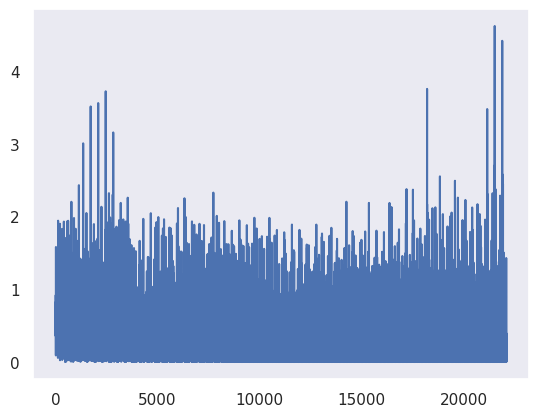

In [20]:
plt.plot(train_losses)

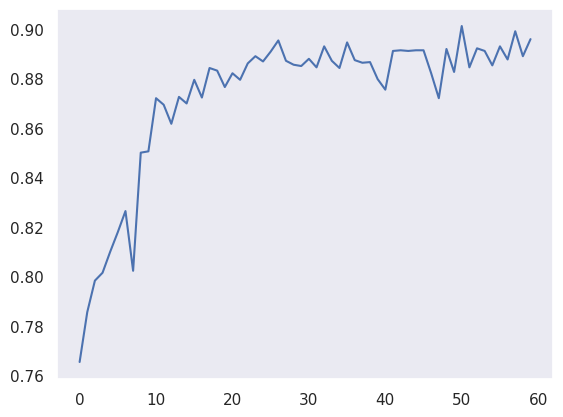

In [21]:
plt.plot(test_accuracy)

In [23]:
metrics2, confusion_matrix2 = report_metrics(model)
pprint(metrics2.compute())
confusion_matrix2.compute()

Correct: 3375/3744 (0.9014)
{'acc_detail': tensor([0.8384, 0.9202], device='cuda:0'),
 'acc_unweighted': tensor(0.8793, device='cuda:0'),
 'acc_weighted': tensor(0.9014, device='cuda:0'),
 'f1s_detail': tensor([0.7962, 0.9350], device='cuda:0'),
 'f1s_unweighted': tensor(0.8656, device='cuda:0'),
 'f1s_weighted': tensor(0.9031, device='cuda:0'),
 'precision_detail': tensor([0.7581, 0.9502], device='cuda:0'),
 'recall_detail': tensor([0.8384, 0.9202], device='cuda:0'),
 'rocauc': tensor(0.9558, device='cuda:0'),
 'rocauc_detail': tensor([0.9558, 0.9558], device='cuda:0'),
 'uar': tensor(0.8793, device='cuda:0'),
 'wap': tensor(0.9061, device='cuda:0')}


tensor([[ 721,  139],
        [ 230, 2654]], device='cuda:0')

In [24]:
model_dir = '../models_physio16k/'
model_path = f'{model_dir}physio16k_fold1_m13mfcc_60epochs.pt' 
torch.save(model.state_dict(), model_path)

In [25]:
checkpoint_path = f'{model_dir}physio16k_fold1_m13mfcc_{epoch}epoch.ckpt'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    # 'best_epoch': best_epoch,
    # 'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)